**Testing the impact of removing variables on a best-performing model**
=================================
-----------------------------------------------------
**<span style="color:red">Tom Wright-Anderson</span>**

Testing the performance of the best-performing model on a dataset with:
- Only precipitation
- Everything but Spen Farm variables
- Only Spen farm variables
- Everything but precipitation

Largely copied functions from original LSTM notebook.

**Loading and creating the 4 separate datasets**
================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import time
import warnings
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
filepath = 'C:/Users/tomwr/Dissertation_Coding/uncleaned_dataset_v2_csv.csv'

date_col = ['Date']
data = pd.read_csv(filepath,
                   parse_dates = date_col,
                   dayfirst = True
                  )
data = data.fillna(method = 'ffill')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264 entries, 0 to 1263
Data columns (total 24 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   Date                                    1264 non-null   datetime64[ns]
 1   SF_absolute_humidity                    1264 non-null   float64       
 2   SF_relative_humidity                    1264 non-null   float64       
 3   SF_mean_air_temperature                 1264 non-null   float64       
 4   SF_atmospheric_pressure                 1264 non-null   float64       
 5   SF_potential_evaporation                1264 non-null   float64       
 6   SF_net_radiation                        1264 non-null   float64       
 7   SF_volumetric_water_content             1264 non-null   float64       
 8   SF_soil_temperature                     1264 non-null   float64       
 9   SF_wind_speed                           1264 non-nul

In [3]:
only_precip_df = data[['catchment_daily_precipitation_armley',
                       'catchment_daily_precipitation_kildwick',
                       'discharge_armley',
                       'headingley_precipitation',
                       'malham_precipitation',
                       'skipton_snaygill_precipitation',
                       'farnley_hall_precipitation',
                       'embsay_precipitation',
                       'silsden_precipitation',
                       'lower_laithe_precipitation',
                       'Date'
                      ]]

only_precip_df = only_precip_df.set_index('Date')


no_sf_df = data[['catchment_daily_precipitation_armley',
                       'catchment_daily_precipitation_kildwick',
                       'discharge_armley',
                       'headingley_precipitation',
                       'malham_precipitation',
                       'skipton_snaygill_precipitation',
                       'farnley_hall_precipitation',
                       'embsay_precipitation',
                       'silsden_precipitation',
                       'lower_laithe_precipitation',
                 'discharge_kildwick',
                 'river_level_snaygill',
                 'river_level_kildwick',
                 'river_level_kirkstall',
                 'Date'
                ]]

no_sf_df = no_sf_df.set_index('Date')


only_sf_df = data[['SF_absolute_humidity',
                   'SF_relative_humidity',
                   'discharge_armley',
                   'SF_mean_air_temperature',
                   'SF_atmospheric_pressure',
                   'SF_potential_evaporation',
                   'SF_net_radiation',
                   'SF_volumetric_water_content',
                   'SF_soil_temperature',
                   'SF_wind_speed',
                   'Date'
                  ]]

only_sf_df = only_sf_df.set_index('Date')


no_precip_df = data[['SF_absolute_humidity',
                   'SF_relative_humidity',
                   'discharge_armley',
                   'SF_mean_air_temperature',
                   'SF_atmospheric_pressure',
                   'SF_potential_evaporation',
                   'SF_net_radiation',
                   'SF_volumetric_water_content',
                   'SF_soil_temperature',
                   'SF_wind_speed',
                   'Date', 
                     'discharge_kildwick',
                 'river_level_snaygill',
                 'river_level_kildwick',
                 'river_level_kirkstall'
                    ]]

no_precip_df = no_precip_df.set_index('Date')


In [4]:
WINDOW_SIZE = 2
FORECAST_LENGTH = 14

**Windowizing dataset function and use**

In [5]:
def windowize_dataset(indexed_dataset, window_size, forecast_length):
    
    #Initializing X (features) and y (target) as empty lists.
    X = []
    y = []
    
    for i in range(len(indexed_dataset) - window_size - forecast_length): 
        X.append(indexed_dataset[i: (i + window_size)]) 
        y.append(indexed_dataset[: -1][i + window_size: i + window_size + forecast_length]) 
    
    #Converting completed list of lists into a numPy array.
    X = np.array(X) 
    
    y = np.array(y) 
    y = y[:, :, 2] 
    
    return np.array(X), np.array(y)

In [6]:
#Only precipitation
op_X, op_y = windowize_dataset(only_precip_df, WINDOW_SIZE, FORECAST_LENGTH)

#No Spen Farm
nsf_X, nsf_y = windowize_dataset(no_sf_df, WINDOW_SIZE, FORECAST_LENGTH)

#Only Spen Farm
osf_X, osf_y = windowize_dataset(only_sf_df, WINDOW_SIZE, FORECAST_LENGTH)

#No precipitation
np_X, np_y = windowize_dataset(no_precip_df, WINDOW_SIZE, FORECAST_LENGTH)



**Splitting into training, validation, testing sets.**

In [7]:
def train_val_test_split(X, y, train_pct, validation_pct):
    
    train_end = round((len(X) / 100) * train_pct)
    validation_end = round((len(X) / 100) * (100 - validation_pct))
    
    X_train, y_train = X[: train_end], y[: train_end]
    X_val, y_val = X[train_end: validation_end], y[train_end: validation_end]
    X_test, y_test = X[validation_end: ], y[validation_end: ]
    
    print(f'\nX_train dimensions: {X_train.shape}, y_train dimensions: {y_train.shape}')
    print(f'X_val dimensions: {X_val.shape}, y_val dimensions: {y_val.shape}')
    print(f'X_test dimensions: {X_test.shape}, y_test dimensions: {y_test.shape}')

    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val), np.array(X_test), np.array(y_test)

In [8]:
#Only precipitation
op_X_train, op_y_train, op_X_val, op_y_val, op_X_test, op_y_test = train_val_test_split(op_X, op_y, 85, 7.5)

#No Spen farm
nsf_X_train, nsf_y_train, nsf_X_val, nsf_y_val, nsf_X_test, nsf_y_test = train_val_test_split(nsf_X, nsf_y, 85, 7.5)

#Only Spen farm
osf_X_train, osf_y_train, osf_X_val, osf_y_val, osf_X_test, osf_y_test = train_val_test_split(osf_X, osf_y, 85, 7.5)

#No precipitation
np_X_train, np_y_train, np_X_val, np_y_val, np_X_test, np_y_test = train_val_test_split(np_X, np_y, 85, 7.5)


X_train dimensions: (1061, 2, 10), y_train dimensions: (1061, 14)
X_val dimensions: (93, 2, 10), y_val dimensions: (93, 14)
X_test dimensions: (94, 2, 10), y_test dimensions: (94, 14)

X_train dimensions: (1061, 2, 14), y_train dimensions: (1061, 14)
X_val dimensions: (93, 2, 14), y_val dimensions: (93, 14)
X_test dimensions: (94, 2, 14), y_test dimensions: (94, 14)

X_train dimensions: (1061, 2, 10), y_train dimensions: (1061, 14)
X_val dimensions: (93, 2, 10), y_val dimensions: (93, 14)
X_test dimensions: (94, 2, 10), y_test dimensions: (94, 14)

X_train dimensions: (1061, 2, 14), y_train dimensions: (1061, 14)
X_val dimensions: (93, 2, 14), y_val dimensions: (93, 14)
X_test dimensions: (94, 2, 14), y_test dimensions: (94, 14)


**Scale data**

In [9]:
def scale_split_data(X_train, X_val, X_test, y_train, y_val, y_test):
    
    #Instantiate separate scalers for features and target.
    feature_scaler = MinMaxScaler(feature_range = (0, 1))
    label_scaler = MinMaxScaler(feature_range = (0, 1))
    
    
    #Features - Breakdown into dimensions, Reformatting in 2D (necessary shape to use MinMaxScaler()), Scaling in 2D using MinMaxScaler fit to features, Reformatting in 3D scaled (necessary shape for inputting into LSTM)
    
    #Breakdown into dimensions
    X_train_sequence, X_train_window, X_train_features = X_train.shape
    X_val_sequence, X_val_window, X_val_features = X_val.shape
    X_test_sequence, X_test_window, X_test_features = X_test.shape
    
    #Reformatting in 2D
    X_train_2D = X_train.reshape(X_train_sequence, X_train_window * X_train_features)
    X_val_2D = X_val.reshape(X_val_sequence, X_val_window * X_val_features)
    X_test_2D = X_test.reshape(X_test_sequence, X_test_window * X_test_features)
    
    #Scaling 2D Feature arrays. Output also in 2D.
    X_train_2D_scaled = feature_scaler.fit_transform(X_train_2D) # fit_transform used on training set only. No part of the model can 'see' the validation or testing sets in advance or this would introduce data leakage.
    X_val_2D_scaled = feature_scaler.transform(X_val_2D)
    X_test_2D_scaled = feature_scaler.transform(X_test_2D)
    
    #Reformatting into 3D Scaled Feature arrays
    X_train_3D_scaled = X_train_2D_scaled.reshape(X_train_sequence, X_train_window, X_train_features)
    X_val_3D_scaled = X_val_2D_scaled.reshape(X_val_sequence, X_val_window, X_val_features)
    X_test_3D_scaled = X_test_2D_scaled.reshape(X_test_sequence, X_test_window, X_test_features)
    
    
    #Labels - Scale using MinMaxScaler fit to labels, Flatten to create Scaled 1D labels (for plotting training metrics), Unscaling flattened labels to produce 1D labels (for use in plotting final results/performance)
    
    #Scaling 2D feature arrays. Output remains in 2D
    y_train_scaled = label_scaler.fit_transform(y_train) # fit_transform again used on training set only to ensure no data leakage.
    y_val_scaled = label_scaler.transform(y_val)
    y_test_scaled = label_scaler.transform(y_test)
    
    #Flattening scaled labels into 1D
    y_train_1D_scaled = y_train_scaled.flatten()
    y_val_1D_scaled = y_val_scaled.flatten()
    y_test_1D_scaled = y_test_scaled.flatten()
    
    #Unscaling 1D labels
    y_train_1D = label_scaler.inverse_transform(y_train_scaled).flatten()
    y_val_1D = label_scaler.inverse_transform(y_val_scaled).flatten()
    y_test_1D = label_scaler.inverse_transform(y_test_scaled).flatten()
    
    
    #Display every returned variable's dimensions for user checking
    print(f'Array dimensions')
    print(f'\nX train 3D scaled: {X_train_3D_scaled.shape}')
    print(f'X validation 3D scaled: {X_val_3D_scaled.shape}')
    print(f'X test 3D scaled: {X_test_3D_scaled.shape}')
    
    print(f'\ny train scaled: {y_train_scaled.shape}')
    print(f'y validation scaled: {y_val_scaled.shape}')
    print(f'y test scaled: {y_test_scaled.shape}')
    
    print(f'\ny train 1D scaled: {y_train_1D_scaled.shape}')
    print(f'y validation 1D scaled: {y_val_1D_scaled.shape}')
    print(f'y test 1D scaled: {y_test_1D_scaled.shape}')
    
    print(f'\ny train 1D: {y_train_1D.shape}')
    print(f'y validation 1D: {y_val_1D.shape}')
    print(f'y test 1D: {y_test_1D.shape}')
    print('')
    print('')
    print('')
    
    #Returning all variables necessary in model training or plotting metrics/performance - Scaled features, Scaled labels, flattened scaled and unscaled labels.
    return X_train_3D_scaled, X_val_3D_scaled, X_test_3D_scaled, y_train_scaled, y_val_scaled, y_test_scaled, y_train_1D_scaled, y_val_1D_scaled, y_test_1D_scaled, y_train_1D, y_val_1D, y_test_1D

In [10]:
#Only precipitation
op_X_train_3D_scaled, op_X_val_3D_scaled, op_X_test_3D_scaled, op_y_train_scaled, op_y_val_scaled, op_y_test_scaled, op_y_train_1D_scaled, op_y_val_1D_scaled, op_y_test_1D_scaled, op_y_train_1D, op_y_val_1D, op_y_test_1D = scale_split_data(op_X_train, op_X_val, op_X_test, op_y_train, op_y_val, op_y_test)

#No Spen Farm
nsf_X_train_3D_scaled, nsf_X_val_3D_scaled, nsf_X_test_3D_scaled, nsf_y_train_scaled, nsf_y_val_scaled, nsf_y_test_scaled, nsf_y_train_1D_scaled, nsf_y_val_1D_scaled, nsf_y_test_1D_scaled, nsf_y_train_1D, nsf_y_val_1D, nsf_y_test_1D = scale_split_data(nsf_X_train, nsf_X_val, nsf_X_test, nsf_y_train, nsf_y_val, nsf_y_test)

#Only Spen Farm
osf_X_train_3D_scaled, osf_X_val_3D_scaled, osf_X_test_3D_scaled, osf_y_train_scaled, osf_y_val_scaled, osf_y_test_scaled, osf_y_train_1D_scaled, osf_y_val_1D_scaled, osf_y_test_1D_scaled, osf_y_train_1D, osf_y_val_1D, osf_y_test_1D = scale_split_data(osf_X_train, osf_X_val, osf_X_test, osf_y_train, osf_y_val, osf_y_test)

#No precipitation
np_X_train_3D_scaled, np_X_val_3D_scaled, np_X_test_3D_scaled, np_y_train_scaled, np_y_val_scaled, np_y_test_scaled, np_y_train_1D_scaled, np_y_val_1D_scaled, np_y_test_1D_scaled, np_y_train_1D, np_y_val_1D, np_y_test_1D = scale_split_data(np_X_train, np_X_val, np_X_test, np_y_train, np_y_val, np_y_test)

Array dimensions

X train 3D scaled: (1061, 2, 10)
X validation 3D scaled: (93, 2, 10)
X test 3D scaled: (94, 2, 10)

y train scaled: (1061, 14)
y validation scaled: (93, 14)
y test scaled: (94, 14)

y train 1D scaled: (14854,)
y validation 1D scaled: (1302,)
y test 1D scaled: (1316,)

y train 1D: (14854,)
y validation 1D: (1302,)
y test 1D: (1316,)



Array dimensions

X train 3D scaled: (1061, 2, 14)
X validation 3D scaled: (93, 2, 14)
X test 3D scaled: (94, 2, 14)

y train scaled: (1061, 14)
y validation scaled: (93, 14)
y test scaled: (94, 14)

y train 1D scaled: (14854,)
y validation 1D scaled: (1302,)
y test 1D scaled: (1316,)

y train 1D: (14854,)
y validation 1D: (1302,)
y test 1D: (1316,)



Array dimensions

X train 3D scaled: (1061, 2, 10)
X validation 3D scaled: (93, 2, 10)
X test 3D scaled: (94, 2, 10)

y train scaled: (1061, 14)
y validation scaled: (93, 14)
y test scaled: (94, 14)

y train 1D scaled: (14854,)
y validation 1D scaled: (1302,)
y test 1D scaled: (1316,)

y t

**Model setup**
===========================

In [11]:
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
from keras.activations import *
from keras.losses import *
from keras.metrics import *
from keras.constraints import *
from keras.regularizers import *
from keras.callbacks import *

#%pip install tensorflow_addons when first running script.
from tensorflow_addons.rnn import PeepholeLSTMCell

In [12]:
#Reduces learning rate by half if val_loss does not decrease to a lower value after 20 epochs
reduce_lr_on_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 20,
                                        factor = 0.5)

#Ends training if val_loss does not decrease after 25 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 30)

In [13]:
models_list = []
model_names_list = []

**Plotting training metrics function**

In [14]:
def plot_training_metrics(history, model_name):
    
    global model_names_list
    
    model_names_list.append(model_name)
    
    history_df = pd.DataFrame(history.history)
    x_axis = np.arange(1, len(history_df) + 1, 1) # Creates a sequence from 1 - end of history at intervals of 1. This represents the number of epochs the model was ran for.
    
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 2,
                           sharex = True,
                           sharey = False
                          )
    fig.set_size_inches(12,12)
    plt.suptitle(f'{model_name} training metrics',
                fontweight = 'bold')
    
    ax[0, 0].plot(x_axis, history_df['loss'], label = 'Training loss')
    ax[0, 0].plot(x_axis, history_df['val_loss'], label = 'Validation loss')
    ax[0, 0].set_title('Loss')
    ax[0, 0].set_ylabel('Loss (Mean Absolute Error)')
    ax[0, 0].set_yscale('log')
    
    ax[0, 1].plot(x_axis, history_df['root_mean_squared_error'], label = 'Training RMSE')
    ax[0, 1].plot(x_axis, history_df['val_root_mean_squared_error'], label = 'Validation RMSE')
    ax[0, 1].set_title('Root Mean Squared Error (RMSE)')
    ax[0, 1].set_ylabel('RMSE')
    ax[0, 1].set_yscale('log')
    
    ax[1, 0].plot(x_axis, history_df['mean_absolute_error'], label = 'Training MAE')
    ax[1, 0].plot(x_axis, history_df['val_mean_absolute_error'], label = 'Validation MAE')
    ax[1, 0].set_title('Mean Absolute Error (MAE)')
    ax[1, 0].set_ylabel('MAE')
    ax[1, 0].set_yscale('log')
    
    ax[1, 1].plot(x_axis, history_df['mean_squared_logarithmic_error'], label = 'Training MSLE')
    ax[1, 1].plot(x_axis, history_df['val_mean_squared_logarithmic_error'], label = 'Validation MSLE')
    ax[1, 1].set_title('Mean Squared Logarithmic Error (MSLE)')
    ax[1, 1].set_ylabel('MSLE')
    ax[1, 1].set_yscale('log')
    
    for ax in ax.flatten():
        ax.set_xlabel('Epoch')
        ax.legend()
    
    plt.tight_layout()
    plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/variable_testing_graphs/{model_name}_training_metrics',
                format = 'jpg')
    plt.show()

**Plotting validation forecast against validation actuals**

In [15]:
def plot_validation_predictions_vs_validation_labels(X_val_3D_scaled, y_train, y_val, y_val_2D_scaled, model, model_name):
   
    global models_list
    models_list.append(model)
    
    #Generate scaled validation predictions
    predictions = model.predict(X_val_3D_scaled)
    
    #Recreate and refit MinMaxScaler to y_train
    label_scaler = MinMaxScaler(feature_range = (0, 1))
    label_scaler.fit_transform(y_train)
    
    #Unscale validation predictions
    unscaled_predictions = label_scaler.inverse_transform(predictions)
    
    #Create 1D numpy arrays of each forecast period's predictions (unscaled)
    unscaled_predictions_1 = unscaled_predictions[:, 0]
    unscaled_predictions_3 = unscaled_predictions[:, 2]
    unscaled_predictions_5 = unscaled_predictions[:, 4]
    unscaled_predictions_7 = unscaled_predictions[:, 6]
    unscaled_predictions_10 = unscaled_predictions[:, 9]
    unscaled_predictions_14 = unscaled_predictions[:, 13]
    
    #Create array of arrays of forecast predictions
    all_unscaled_validation_predictions = np.asarray([unscaled_predictions_1,
                                                   unscaled_predictions_3,
                                                   unscaled_predictions_5,
                                                   unscaled_predictions_7,
                                                   unscaled_predictions_10,
                                                   unscaled_predictions_14]
                                                  )
    print(all_unscaled_validation_predictions.shape)
    #Generating figure with plots
    
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 3,
                           sharex = True,
                           sharey = True
                          )
    fig.set_size_inches(14, 14)
    plt.suptitle(f'Model {model_name} validation predicted forecasts against actual conditions',
                fontweight = 'bold')
    
    #Plotting validation predictions vs. actuals for each forecast period.
    
    ax[0, 0].plot(unscaled_predictions_1, label = 'Predicted')
    ax[0, 0].plot(y_val[:, 0], label = 'Actual')
    ax[0, 0].set_title('1 day forecast')
    
    ax[0, 1].plot(unscaled_predictions_3, label = 'Predicted')
    ax[0, 1].plot(y_val[:, 2], label = 'Actual')
    ax[0, 1].set_title('3 day forecast')
    
    ax[0, 2].plot(unscaled_predictions_5, label = 'Predicted')
    ax[0, 2].plot(y_val[:, 4], label = 'Actual')
    ax[0, 2].set_title('5 day forecast')
    
    ax[1, 0].plot(unscaled_predictions_7, label = 'Predicted')
    ax[1, 0].plot(y_val[:, 6], label = 'Actual')
    ax[1, 0].set_title('7 day forecast')
    
    ax[1, 1].plot(unscaled_predictions_10, label = 'Predicted')
    ax[1, 1].plot(y_val[:, 9], label = 'Actual')
    ax[1, 1].set_title('10 day forecast')
    
    ax[1, 2].plot(unscaled_predictions_14, label = 'Predicted')
    ax[1, 2].plot(y_val[:, 13], label = 'Actual')
    ax[1, 2].set_title('14 day forecast')
    
    for ax in ax.flatten():
        ax.legend()
        ax.set_ylabel('Discharge m³/s')
        ax.set_xlabel('Days (within Validation period)')
    
    plt.tight_layout()
    plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/variable_testing_graphs/{model_name}_val_predictions_vs_val_labels',
                format = 'jpg')
    plt.show()

        
    
    #Create 1D numpy arrays of each forecast period's predictions (scaled)
    predictions_1 = predictions[:, 0]
    predictions_3 = predictions[:, 2]
    predictions_5 = predictions[:, 4]
    predictions_7 = predictions[:, 6]
    predictions_10 = predictions[:, 9]
    predictions_14 = predictions[:, 13]
    
    #Calcute RMSE and MAE of each forecast period
    predictions_1_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 0], predictions_1))
    predictions_1_mae =  np.array(mean_absolute_error(y_val_2D_scaled[:, 0], predictions_1))
    
    predictions_3_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 2], predictions_3))
    predictions_3_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 2], predictions_3))
    
    predictions_5_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 4], predictions_5))
    predictions_5_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 4], predictions_5))
    
    predictions_7_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 6], predictions_7))
    predictions_7_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 6], predictions_7))
    
    predictions_10_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 9], predictions_10))
    predictions_10_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 9], predictions_10))
    
    predictions_14_rmse = math.sqrt(mean_squared_error(y_val_2D_scaled[:, 13], predictions_14))
    predictions_14_mae = np.array(mean_absolute_error(y_val_2D_scaled[:, 13], predictions_14))
        
    #Create a dataframe to add each value.
    validation_results_df = pd.DataFrame(columns = ['model_name',
                                                    '1_day_forecast_rmse',
                                                    '1_day_forecast_mae',
                                                    '3_day_forecast_rmse',
                                                    '3_day_forecast_mae',
                                                    '5_day_forecast_rmse',
                                                    '5_day_forecast_mae',
                                                    '7_day_forecast_rmse',
                                                    '7_day_forecast_mae',
                                                    '10_day_forecast_rmse',
                                                    '10_day_forecast_mae',
                                                    '14_day_forecast_rmse',
                                                    '14_day_forecast_mae'
                                                   ])
    
    #Adding each value in correct column.
    validation_results_df.at[0, 'model_name'] = model_name
    
    validation_results_df['1_day_forecast_rmse'] = predictions_1_rmse
    validation_results_df['1_day_forecast_mae'] = predictions_1_mae
    
    validation_results_df['3_day_forecast_rmse'] = predictions_3_rmse
    validation_results_df['3_day_forecast_mae'] = predictions_3_mae
    
    validation_results_df['5_day_forecast_rmse'] = predictions_5_rmse
    validation_results_df['5_day_forecast_mae'] = predictions_5_mae
    
    validation_results_df['7_day_forecast_rmse'] = predictions_7_rmse
    validation_results_df['7_day_forecast_mae'] = predictions_7_mae
    
    validation_results_df['10_day_forecast_rmse'] = predictions_10_rmse
    validation_results_df['10_day_forecast_mae'] = predictions_10_mae
    
    validation_results_df['14_day_forecast_rmse'] = predictions_14_rmse
    validation_results_df['14_day_forecast_mae'] = predictions_14_mae
    
    #return validation results df for use, and unscaled validation predictions
    return validation_results_df, all_unscaled_validation_predictions

**Plot test forecasts vs. test actuals**

In [16]:
def plot_test_predictions_vs_test_labels(X_test_3D_scaled, y_train, y_test, y_test_2D_scaled, model, model_name):
    
    #Generate scaled validation predictions
    predictions = model.predict(X_test_3D_scaled)
    
    #Recreate and refit MinMaxScaler to y_train
    label_scaler = MinMaxScaler(feature_range = (0, 1))
    label_scaler.fit_transform(y_train)
    
    #Unscale test predictions
    unscaled_predictions = label_scaler.inverse_transform(predictions)
    
    #Create 1D numpy arrays of each forecast period's predictions (unscaled)
    unscaled_predictions_1 = unscaled_predictions[:, 0]
    unscaled_predictions_3 = unscaled_predictions[:, 2]
    unscaled_predictions_5 = unscaled_predictions[:, 4]
    unscaled_predictions_7 = unscaled_predictions[:, 6]
    unscaled_predictions_10 = unscaled_predictions[:, 9]
    unscaled_predictions_14 = unscaled_predictions[:, 13]
    
    #Create array of arrays of forecast predictions
    all_unscaled_test_predictions = np.asarray([unscaled_predictions_1,
                                        unscaled_predictions_3,
                                        unscaled_predictions_5,
                                        unscaled_predictions_7,
                                        unscaled_predictions_10,
                                        unscaled_predictions_14]
                                              )
    
    print(all_unscaled_test_predictions.shape)
    #Generating figure with plots
    
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 3,
                           sharex = True,
                           sharey = True
                          )
    fig.set_size_inches(14, 14)
    plt.suptitle(f'Model {model_name} test predicted forecasts against actual conditions',
                fontweight = 'bold')
    
    #Plotting validation predictions vs. actuals for each forecast period.
    
    ax[0, 0].plot(unscaled_predictions_1, label = 'Predicted')
    ax[0, 0].plot(y_test[:, 0], label = 'Actual')
    ax[0, 0].set_title('1 day forecast')
    
    ax[0, 1].plot(unscaled_predictions_3, label = 'Predicted')
    ax[0, 1].plot(y_test[:, 2], label = 'Actual')
    ax[0, 1].set_title('3 day forecast')
    
    ax[0, 2].plot(unscaled_predictions_5, label = 'Predicted')
    ax[0, 2].plot(y_test[:, 4], label = 'Actual')
    ax[0, 2].set_title('5 day forecast')
    
    ax[1, 0].plot(unscaled_predictions_7, label = 'Predicted')
    ax[1, 0].plot(y_test[:, 6], label = 'Actual')
    ax[1, 0].set_title('7 day forecast')
    
    ax[1, 1].plot(unscaled_predictions_10, label = 'Predicted')
    ax[1, 1].plot(y_test[:, 9], label = 'Actual')
    ax[1, 1].set_title('10 day forecast')
    
    ax[1, 2].plot(unscaled_predictions_14, label = 'Predicted')
    ax[1, 2].plot(y_test[:, 13], label = 'Actual')
    ax[1, 2].set_title('14 day forecast')
    
    for ax in ax.flatten():
        ax.legend()
        ax.set_ylabel('Discharge m³/s')
        ax.set_xlabel('Days (within testing period)')
    
    plt.tight_layout()
    #plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/variable_testing_graphs/{model_name}_test_predictions_vs_test_labels',
                #format = 'jpg')
    plt.show()

        
    
    #Create 1D numpy arrays of each forecast period's predictions (scaled)
    predictions_1 = predictions[:, 0]
    predictions_3 = predictions[:, 2]
    predictions_5 = predictions[:, 4]
    predictions_7 = predictions[:, 6]
    predictions_10 = predictions[:, 9]
    predictions_14 = predictions[:, 13]
    
    #Calcute RMSE and MAE of each forecast period
    predictions_1_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 0], predictions_1))
    predictions_1_mae =  np.array(mean_absolute_error(y_test_2D_scaled[:, 0], predictions_1))
    
    predictions_3_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 2], predictions_3))
    predictions_3_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 2], predictions_3))
    
    predictions_5_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 4], predictions_5))
    predictions_5_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 4], predictions_5))
    
    predictions_7_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 6], predictions_7))
    predictions_7_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 6], predictions_7))
    
    predictions_10_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 9], predictions_10))
    predictions_10_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 9], predictions_10))
    
    predictions_14_rmse = math.sqrt(mean_squared_error(y_test_2D_scaled[:, 13], predictions_14))
    predictions_14_mae = np.array(mean_absolute_error(y_test_2D_scaled[:, 13], predictions_14))
        
    #Create a dataframe to add each value.
    test_results_df = pd.DataFrame(columns = ['model_name',
                                                    '1_day_forecast_rmse',
                                                    '1_day_forecast_mae',
                                                    '3_day_forecast_rmse',
                                                    '3_day_forecast_mae',
                                                    '5_day_forecast_rmse',
                                                    '5_day_forecast_mae',
                                                    '7_day_forecast_rmse',
                                                    '7_day_forecast_mae',
                                                    '10_day_forecast_rmse',
                                                    '10_day_forecast_mae',
                                                    '14_day_forecast_rmse',
                                                    '14_day_forecast_mae'
                                                   ])
    
    #Adding each value in correct column.
    test_results_df.at[0, 'model_name'] = model_name
    
    test_results_df['1_day_forecast_rmse'] = predictions_1_rmse
    test_results_df['1_day_forecast_mae'] = predictions_1_mae
    
    test_results_df['3_day_forecast_rmse'] = predictions_3_rmse
    test_results_df['3_day_forecast_mae'] = predictions_3_mae
    
    test_results_df['5_day_forecast_rmse'] = predictions_5_rmse
    test_results_df['5_day_forecast_mae'] = predictions_5_mae
    
    test_results_df['7_day_forecast_rmse'] = predictions_7_rmse
    test_results_df['7_day_forecast_mae'] = predictions_7_mae
    
    test_results_df['10_day_forecast_rmse'] = predictions_10_rmse
    test_results_df['10_day_forecast_mae'] = predictions_10_mae
    
    test_results_df['14_day_forecast_rmse'] = predictions_14_rmse
    test_results_df['14_day_forecast_mae'] = predictions_14_mae
    
    #########################################################################
    #Display a bar chart of test error at each forecast period interval
    plt.figure(2)
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 6)
    
    plt.suptitle(f'{model_name} test error for each forecast period',
                fontweight = 'bold')
    
    forecast_labels = ['1 day', '3 day', '5 day', '7 day', '10 day', '14 day']
    forecast_nums = [0, 1, 2, 3, 4, 5]
    x_len = np.arange(len(forecast_labels))
    bar_width = 0.3
    
    rmse_vals = [predictions_1_rmse, predictions_3_rmse, predictions_5_rmse, predictions_7_rmse, predictions_10_rmse, predictions_14_rmse]
    mae_vals = [predictions_1_mae, predictions_3_mae, predictions_5_mae, predictions_7_mae, predictions_10_mae, predictions_14_mae]
    
    rects1 = ax.bar(x_len - bar_width/2, rmse_vals, bar_width, label='RMSE')
    rects2 = ax.bar(x_len + bar_width/2, mae_vals, bar_width, label='MAE')
     
    
    ax.set_ylabel('Error')
    ax.set_xticks(forecast_nums, forecast_labels)
    ax.legend()
    
    plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/variable_testing_graphs/{model_name}_test_error_by_period',
                format = 'jpg')
    plt.tight_layout()
    plt.show()
    
    #return test_results_df and unscaled_test_predictions
    return test_results_df, all_unscaled_test_predictions

**Plot validation and test forecast predictions vs actual conditions**

In [17]:
def plot_all_model_predictions_vs_actuals(validation_predictions_array, test_predictions_array, model_name, actual_values, X_train, X_val, X_test):
    
    #Split prediction arrays into forecast periods
    print(validation_predictions_array.shape)
    validation_predictions_1 = validation_predictions_array[0]
    validation_predictions_3 = validation_predictions_array[1]
    validation_predictions_5 = validation_predictions_array[2]
    validation_predictions_7 = validation_predictions_array[3]
    validation_predictions_10 = validation_predictions_array[4]
    validation_predictions_14 = validation_predictions_array[5]
    
    test_predictions_1 = test_predictions_array[0]
    test_predictions_3 = test_predictions_array[1]
    test_predictions_5 = test_predictions_array[2]
    test_predictions_7 = test_predictions_array[3]
    test_predictions_10 = test_predictions_array[4]
    test_predictions_14 = test_predictions_array[5]
    
    #Lengths to plot
    train_len = len(X_train)
    val_len = len(X_train) + len(X_val)
    test_len = len(X_train) + len(X_val) + len(X_test)
    
    #Create subplots grid 2 rows, 1 column
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 1,
                           sharex = True,
                           sharey = False
                          )
    fig.set_size_inches(12, 10)
    plt.suptitle('validation and test predictions vs. actual conditions',
                 fontweight = 'bold'
                )
    
    #Upper plot - 1, 3, 5 days
    ax[0, ].set_title(f'{model_name} predicted forecasts vs actual conditions - 1, 3, 5 day')
    ax[0, ].plot(range(train_len, test_len), actual_values[train_len:, 0], color = 'black', label = 'Actual discharge')
    ax[0, ].plot(range(train_len, val_len), validation_predictions_1, color = 'green', linestyle = 'dashed', label = '1 day validation forecast')
    ax[0, ].plot(range(train_len, val_len), validation_predictions_3, color = 'orange', linestyle = 'dashed', label = '3 day validation forecast')
    ax[0, ].plot(range(train_len, val_len), validation_predictions_5, color = 'red', linestyle = 'dashed', label = '5 day validation forecast')
    
    ax[0, ].plot(range(val_len, test_len), test_predictions_1, color = 'green', linestyle = 'dotted', label = '1 day test forecast')
    ax[0, ].plot(range(val_len, test_len), test_predictions_3, color = 'orange', linestyle = 'dotted', label = '3 day test forecast')
    ax[0, ].plot(range(val_len, test_len), test_predictions_5, color = 'red', linestyle = 'dotted', label = '5 day test forecast')
    
    
    #Lower plot - 7, 10, 14 day
    ax[1, ].set_title(f'{model_name} predicted forecasts vs actual conditions - 7, 10, 14 day')
    ax[1, ].plot(range(train_len, test_len), actual_values[train_len:, 0], color = 'black', label = 'Actual discharge')
    ax[1, ].plot(range(train_len, val_len), validation_predictions_7, color = 'green', linestyle = 'dashed', label = '7 day validation forecast')
    ax[1, ].plot(range(train_len, val_len), validation_predictions_10, color = 'orange', linestyle = 'dashed', label = '10 day validation forecast')
    ax[1, ].plot(range(train_len, val_len), validation_predictions_14, color = 'red', linestyle = 'dashed', label = '14 day validation forecast')
    
    ax[1, ].plot(range(val_len, test_len), test_predictions_7, color = 'green', linestyle = 'dotted', label = '7 day test forecast')
    ax[1, ].plot(range(val_len, test_len), test_predictions_10, color = 'orange', linestyle = 'dotted', label = '10 day test forecast')
    ax[1, ].plot(range(val_len, test_len), test_predictions_14, color = 'red', linestyle = 'dotted', label = '14 day test forecast')
    
    for ax in ax.flatten():
        ax.set_ylabel('Discharge m³/s')
        ax.legend()
    
    plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/variable_testing_graphs/{model_name}_all_model_predictions_vs_actuals',
                format = 'jpg')
    plt.show()
   

**Plot just test forecasts against actuals**

In [18]:
def plot_model_test_predictions_vs_actuals(test_predictions_array, model_name, actual_values, X_train, X_val, X_test):
    
    test_predictions_1 = test_predictions_array[0]
    test_predictions_3 = test_predictions_array[1]
    test_predictions_5 = test_predictions_array[2]
    test_predictions_7 = test_predictions_array[3]
    test_predictions_10 = test_predictions_array[4]
    test_predictions_14 = test_predictions_array[5]
    
    train_len = len(X_train)
    val_len = len(X_train) + len(X_val)
    test_len = len(X_train) + len(X_val) + len(X_test)
    
    fig, ax = plt.subplots(nrows = 2,
                           ncols = 1,
                           sharex = True,
                           sharey = True
                          )
    
    fig.set_size_inches(12, 8)
    plt.suptitle(f'{model_name} test predictions vs. actual values',
                fontweight = 'bold')
    
    ax[0, ].set_title('1, 3, 5 day forecast predictions vs. actual discharge')
    ax[0, ].plot(range(val_len, test_len), actual_values[val_len:, 0], color = 'black', label = 'Actual discharge')
    ax[0, ].plot(range(val_len, test_len), test_predictions_1, color = 'green', linestyle = 'dotted', label = '1 day test forecast')
    ax[0, ].plot(range(val_len, test_len), test_predictions_3, color = 'orange', linestyle = 'dotted', label = '3 day test forecast')
    ax[0, ].plot(range(val_len, test_len), test_predictions_5, color = 'red', linestyle = 'dotted', label = '5 day test forecast')
    
    
    ax[1, ].set_title('7, 10, 14 day forecast predictions vs. actual discharge')
    ax[1, ].plot(range(val_len, test_len), actual_values[val_len:, 0], color = 'black', label = 'Actual discharge')
    ax[1, ].plot(range(val_len, test_len), test_predictions_7, color = 'green', linestyle = 'dotted', label = '7 day test forecast')
    ax[1, ].plot(range(val_len, test_len), test_predictions_10, color = 'orange', linestyle = 'dotted', label = '10 day test forecast')
    ax[1, ].plot(range(val_len, test_len), test_predictions_14, color = 'red', linestyle = 'dotted', label = '14 day test forecast')
    
    for ax in ax.flatten():
        ax.set_ylabel('Discharge m³/s')
        ax.legend()
    
    plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/variable_testing_graphs/{model_name}_test_predictions_vs_actuals',
                format = 'jpg')
    plt.show()

**Plotting models overall test metrics**

In [19]:
def plot_all_model_test_metrics(model_list, model_name_list, X_test_3D_scaled, y_test_2D_scaled):
    
    model_metrics_df = pd.DataFrame(columns = ['loss',
                                               'root_mean_squared_error',
                                               'mean_absolute_error',
                                               'mean_squared_logarithmic_error'
                                              ])
    
    count = -1
    for i in model_list:
        count = count + 1
        metrics_dict = i.evaluate(X_test_3D_scaled,
                                  y_test_2D_scaled,
                                  return_dict = True
                                 )
        model_metrics_df.at[count, 'loss'] = metrics_dict.get('loss')
        model_metrics_df.at[count, 'root_mean_squared_error'] = metrics_dict.get('root_mean_squared_error')
        model_metrics_df.at[count, 'mean_absolute_error'] = metrics_dict.get('mean_absolute_error')
        model_metrics_df.at[count, 'mean_squared_logarithmic_error'] = metrics_dict.get('mean_squared_logarithmic_error')
    
    
    #Convert list of names into a pandas series.
    model_name_series = pd.Series(model_name_list)
    
    model_metrics_df.insert(0, 'model_name', model_name_series)

    fig, ax = plt.subplots(nrows = 1,
                           ncols = 3,
                           sharex = True,
                           sharey = False
                          )
    fig.set_size_inches(12, 10)
    
    plt.suptitle('Overall test metrics',
                fontweight = 'bold')
    
    ax[0].set_title('Root Mean Squared Error')
    ax[0].bar(model_metrics_df['model_name'], model_metrics_df['root_mean_squared_error'])
    ax[0].set_ylabel('RMSE')
    ax[0].set_yscale('log')
    
    ax[1].set_title('Mean Absolute Error')
    ax[1].bar(model_metrics_df['model_name'], model_metrics_df['mean_absolute_error'])
    ax[1].set_ylabel('MAE')
    ax[1].set_yscale('log')
    
    ax[2].set_title('Mean Squared Logarithmic Error')
    ax[2].bar(model_metrics_df['model_name'], model_metrics_df['mean_squared_logarithmic_error'])
    ax[2].set_ylabel('MSLE')
    ax[2].set_yscale('log')
    
   
    plt.xticks(rotation = 30)
    plt.tight_layout()
    
    
    
    
    
    plt.tight_layout()
    
    plt.savefig(fname = f'D:/Year 3/GEOG3605 - Dissertation/model_graphs/variable_testing_graphs/all_model_test_metrics_bar',
                format = 'jpg')
    plt.show()
    
    return model_metrics_df

**Training models**
===================

- 1 model architecture (the best from previous testing) will be used - Best overall test rmse - bidirectional 2 layer 32 unit regularized peephole lstm.
- 4 training runs are required, 1 for each different dataset type. 
- For each training run, a clear different model_name will be used.
- For each training run, the above functions will be run in the order they're intiialized.

Model run 1: Only Precipitation (op)

Model run 2: No Spen Farm (nsf)

Model run 3: Only Spen Farm (osf)

Model run 4: No precipitation (np)

**Model run 1: - Only precipitation**

In [20]:
op_bi_p_lstm_2_32_reg_name = 'op_bi_p_LSTM_2_32_reg'

op_bi_p_lstm_2_32_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, input_shape = op_X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

op_bi_p_lstm_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

op_bi_p_lstm_2_32_reg_hist = op_bi_p_lstm_2_32_reg.fit(op_X_train_3D_scaled, op_y_train_scaled,
                            validation_data = (op_X_val_3D_scaled, op_y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 8s 30ms/step - loss: 0.0555 - root_mean_squared_error: 0.1029 - mean_absolute_error: 0.0555 - mean_squared_logarithmic_error: 0.0068 - val_loss: 0.0996 - val_root_mean_squared_error: 0.1589 - val_mean_absolute_error: 0.0996 - val_mean_squared_logarithmic_error: 0.0168 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0485 - root_mean_squared_error: 0.0965 - mean_absolute_error: 0.0485 - mean_squared_logarithmic_error: 0.0062 - val_loss: 0.0951 - val_root_mean_squared_error: 0.1525 - val_mean_absolute_error: 0.0951 - val_mean_squared_logarithmic_error: 0.0153 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 7ms/step - loss: 0.0480 - root_mean_squared_error: 0.0952 - mean_absolute_error: 0.0480 - mean_squared_logarithmic_error: 0.0060 - val_loss: 0.1025 - val_root_mean_squared_error: 0.1620 - val_mean_absolute_error: 0.1025 - val_mean_squared_logarithmic_error: 0.0176 - lr: 0.00

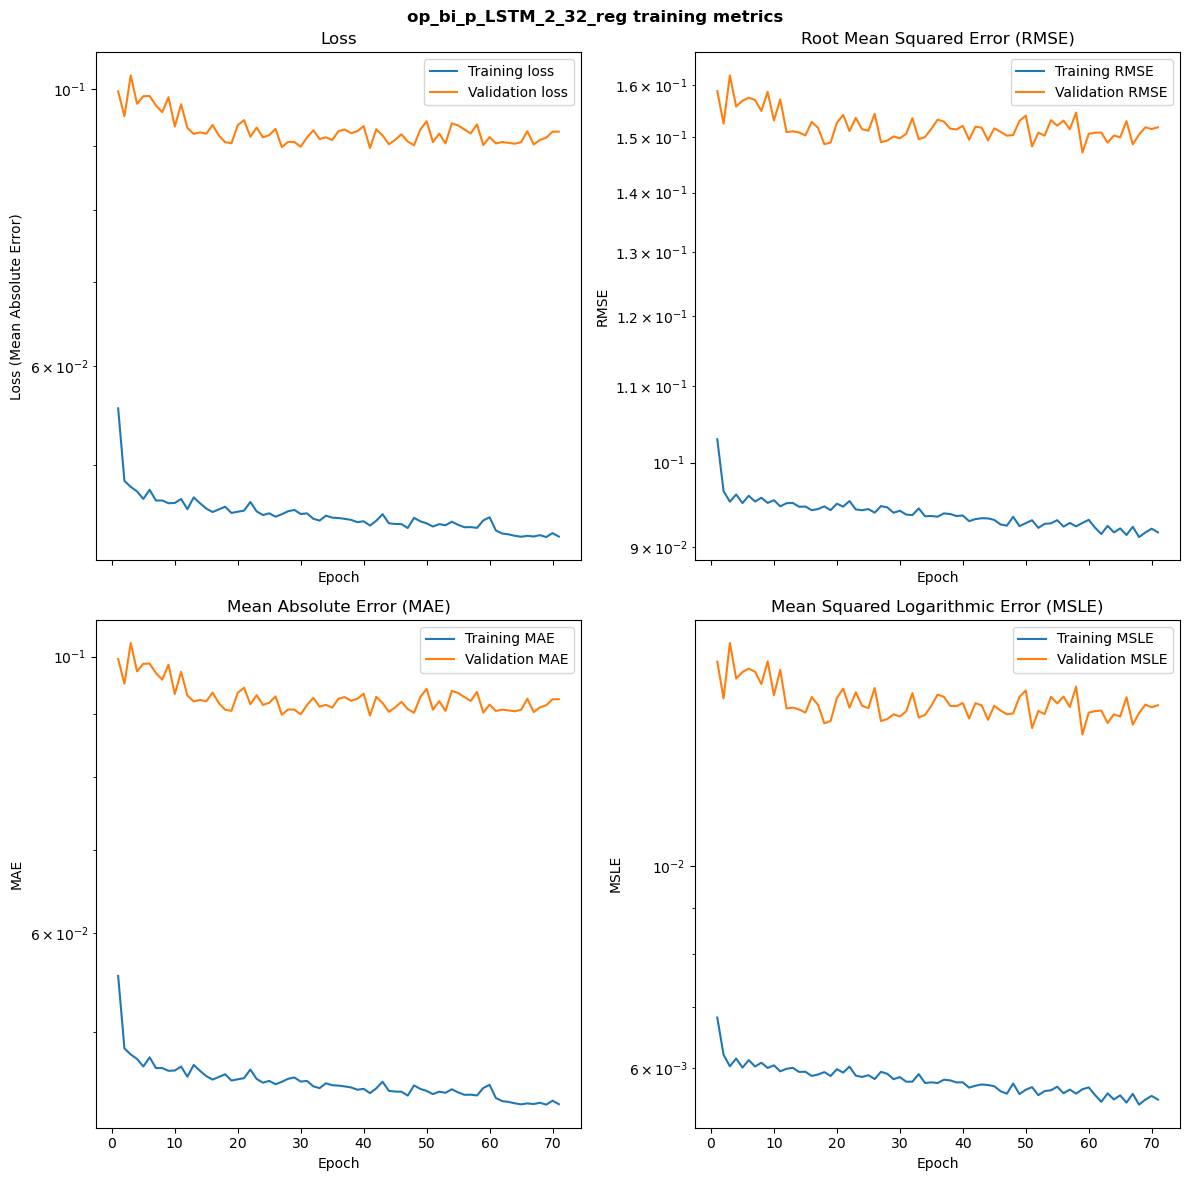

3/3 [==============================] - 1s 3ms/step
(6, 93)


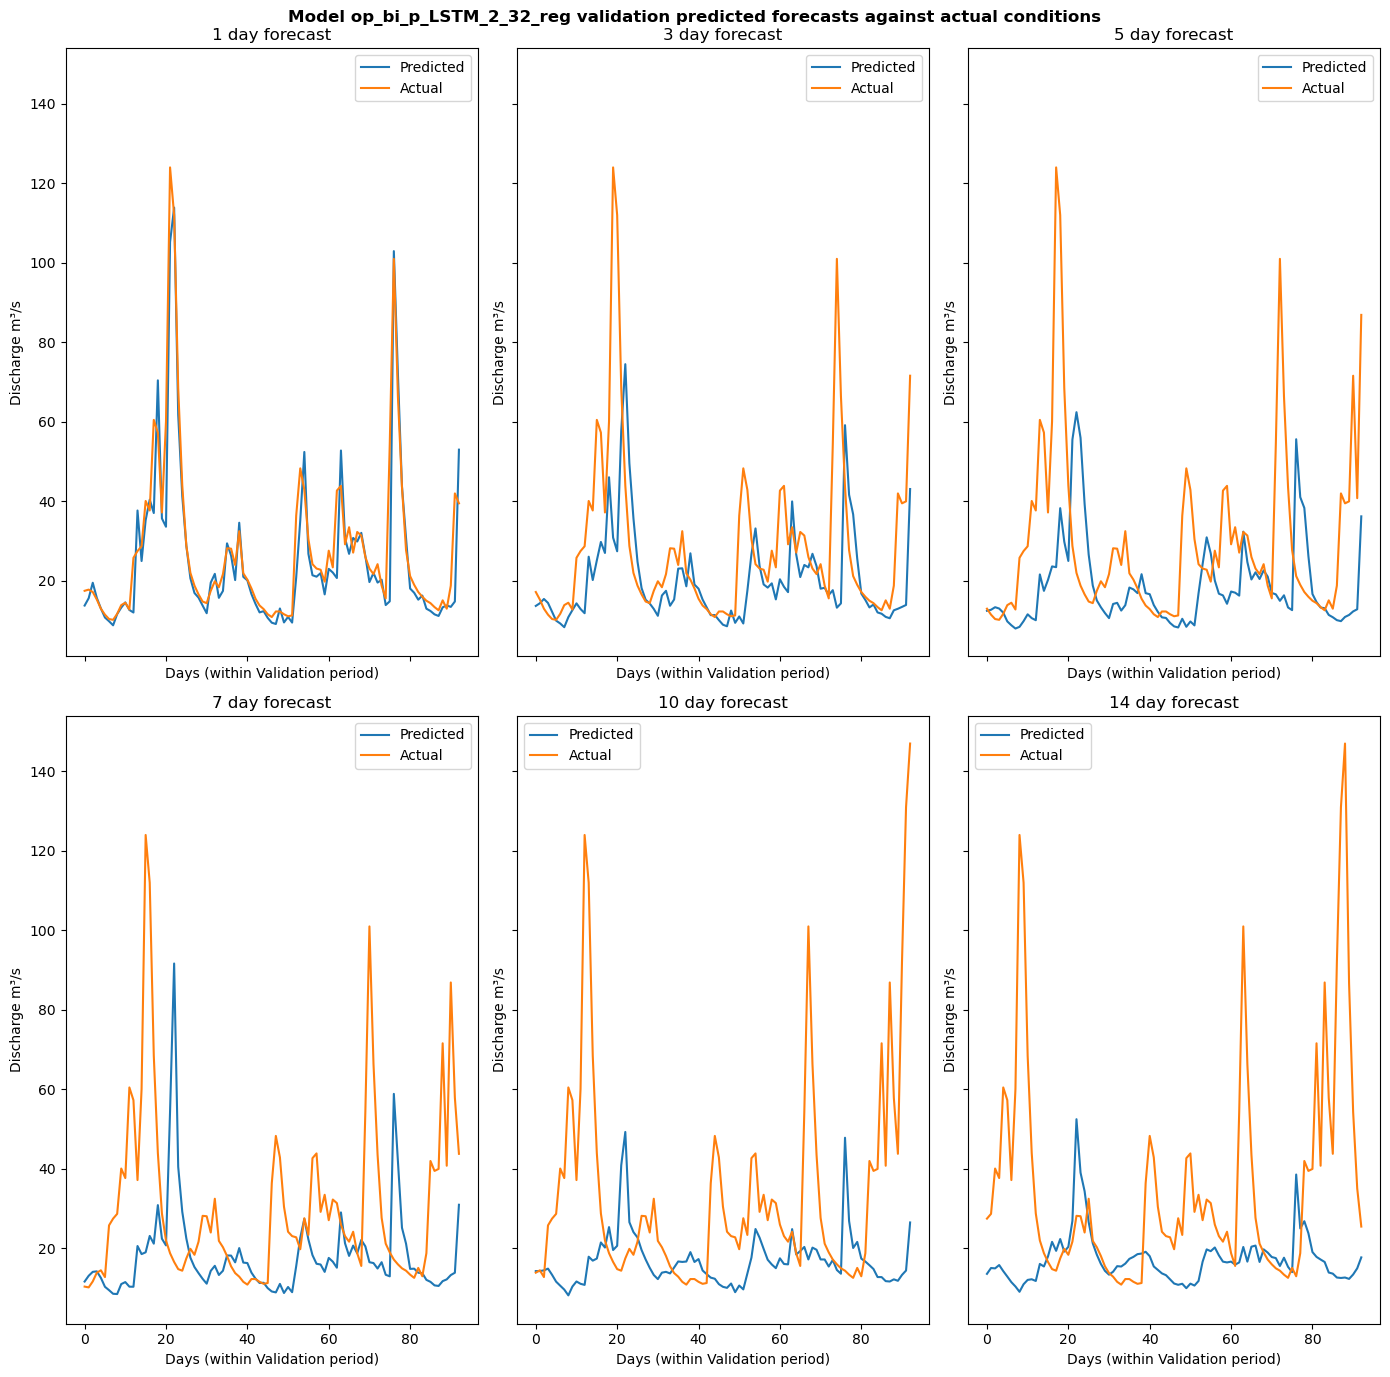

3/3 [==============================] - 0s 3ms/step
(6, 94)


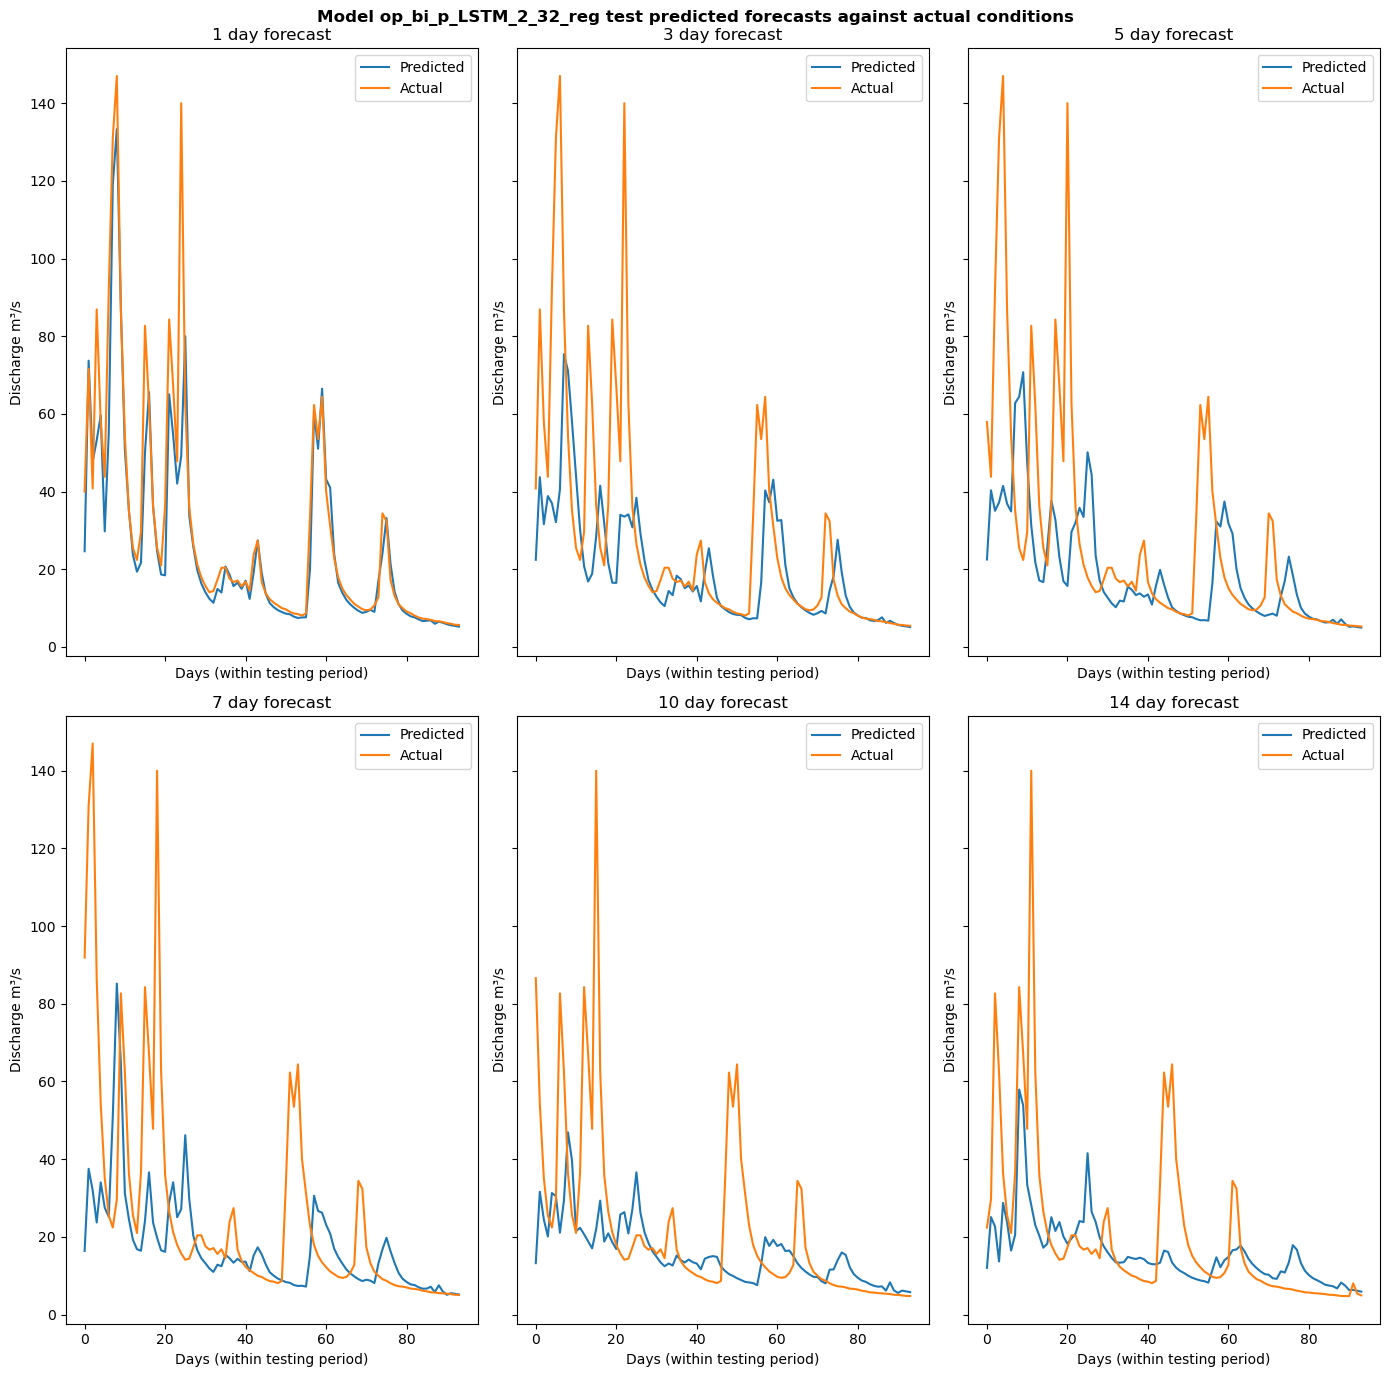

<Figure size 640x480 with 0 Axes>

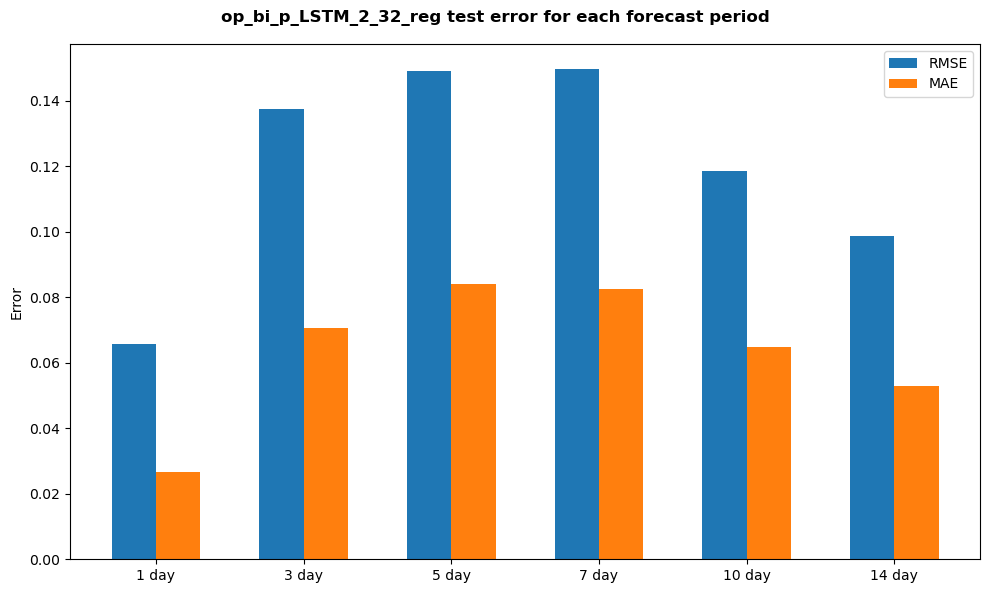

(6, 93)


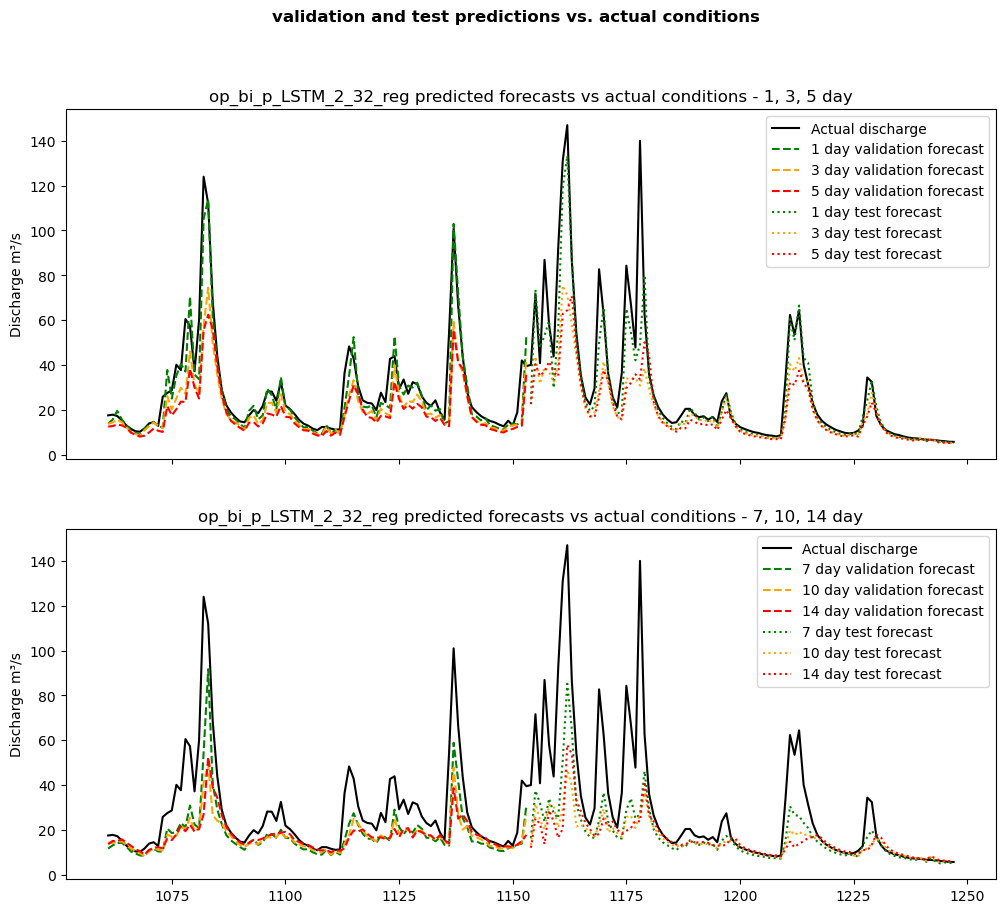

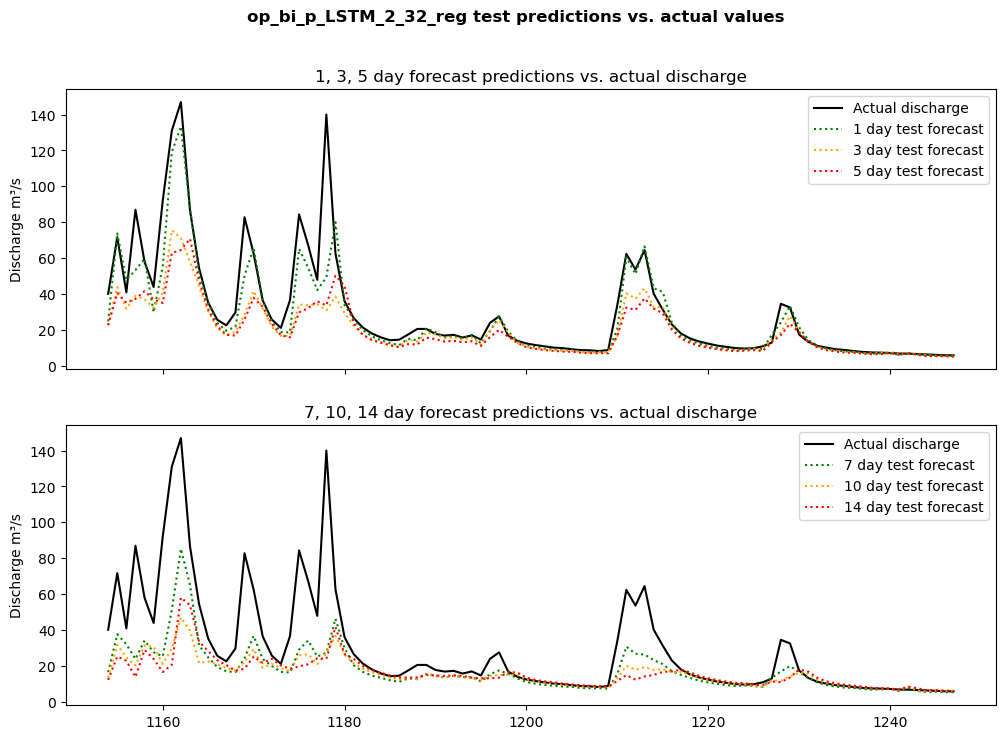

In [21]:
plot_training_metrics(op_bi_p_lstm_2_32_reg_hist, op_bi_p_lstm_2_32_reg_name)

op_bi_p_lstm_2_32_reg_val_results_df, op_bi_p_lstm_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(op_X_val_3D_scaled, op_y_train, op_y_val, op_y_val_scaled, op_bi_p_lstm_2_32_reg, op_bi_p_lstm_2_32_reg_name)

op_bi_p_lstm_2_32_reg_test_results_df, op_bi_p_lstm_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(op_X_test_3D_scaled, op_y_train, op_y_test, op_y_test_scaled, op_bi_p_lstm_2_32_reg, op_bi_p_lstm_2_32_reg_name)

plot_all_model_predictions_vs_actuals(op_bi_p_lstm_2_32_reg_all_val_predictions, op_bi_p_lstm_2_32_reg_all_test_predictions, op_bi_p_lstm_2_32_reg_name, op_y, op_X_train, op_X_val, op_X_test)

plot_model_test_predictions_vs_actuals(op_bi_p_lstm_2_32_reg_all_test_predictions, op_bi_p_lstm_2_32_reg_name, op_y, op_X_train, op_X_val, op_X_test)

**Model run 2:- No Spen Farm**

In [22]:
nsf_bi_p_lstm_2_32_reg_name = 'nsf_bi_p_LSTM_2_32_reg'

nsf_bi_p_lstm_2_32_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, input_shape = nsf_X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

nsf_bi_p_lstm_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

nsf_bi_p_lstm_2_32_reg_hist = nsf_bi_p_lstm_2_32_reg.fit(nsf_X_train_3D_scaled, nsf_y_train_scaled,
                            validation_data = (nsf_X_val_3D_scaled, nsf_y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 8s 28ms/step - loss: 0.0524 - root_mean_squared_error: 0.0995 - mean_absolute_error: 0.0524 - mean_squared_logarithmic_error: 0.0064 - val_loss: 0.0995 - val_root_mean_squared_error: 0.1598 - val_mean_absolute_error: 0.0995 - val_mean_squared_logarithmic_error: 0.0170 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0478 - root_mean_squared_error: 0.0957 - mean_absolute_error: 0.0478 - mean_squared_logarithmic_error: 0.0061 - val_loss: 0.1008 - val_root_mean_squared_error: 0.1609 - val_mean_absolute_error: 0.1008 - val_mean_squared_logarithmic_error: 0.0173 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0472 - root_mean_squared_error: 0.0951 - mean_absolute_error: 0.0472 - mean_squared_logarithmic_error: 0.0059 - val_loss: 0.0954 - val_root_mean_squared_error: 0.1554 - val_mean_absolute_error: 0.0954 - val_mean_squared_logarithmic_error: 0.0159 - lr: 0.00

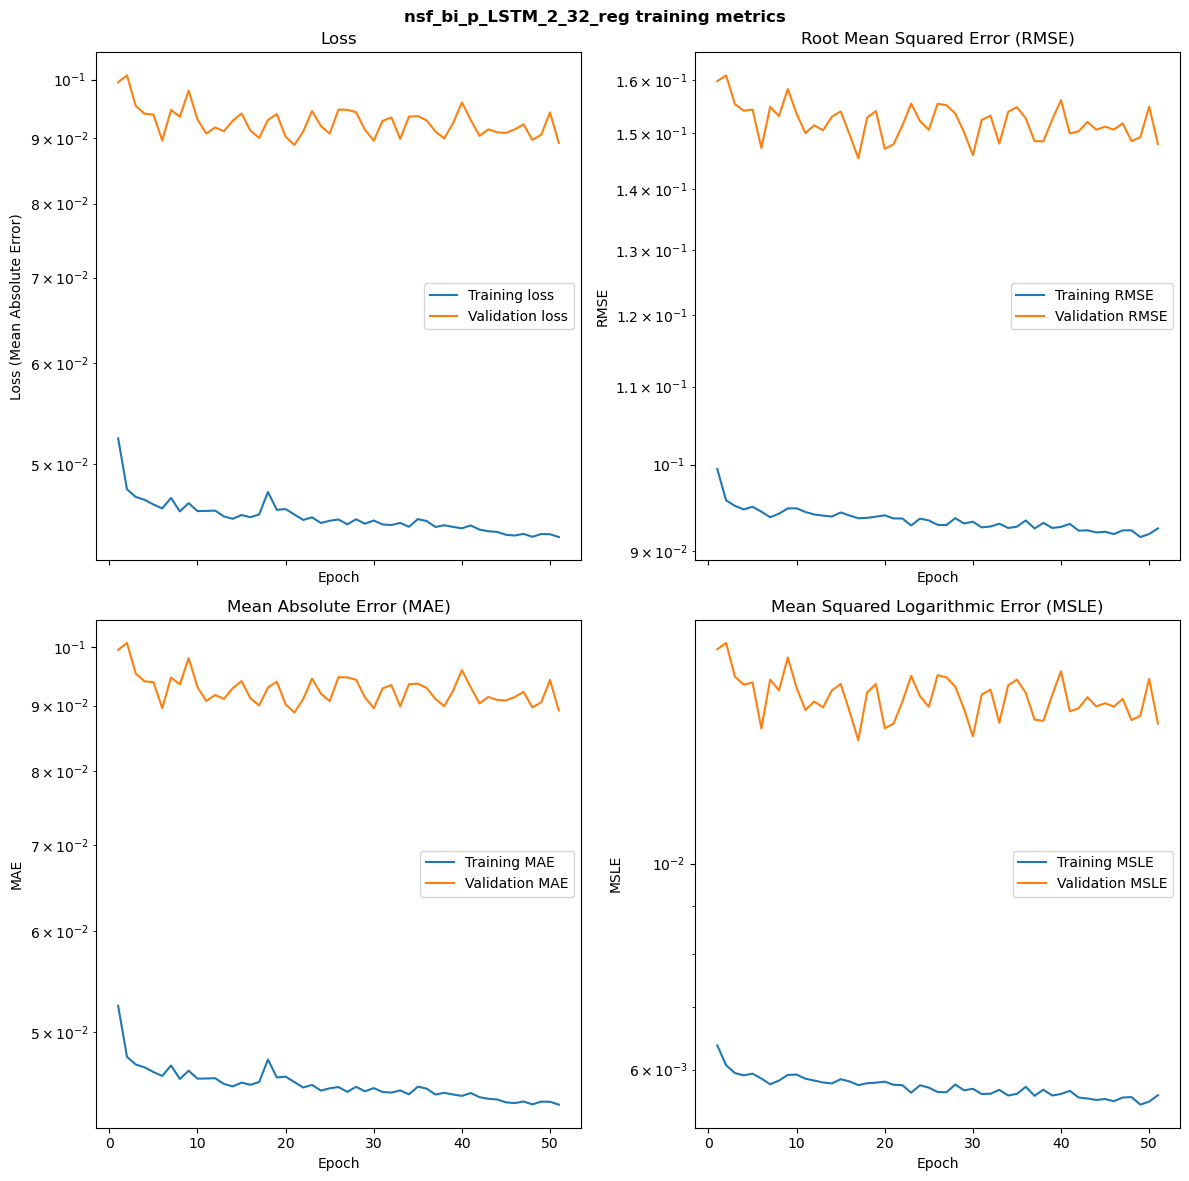

3/3 [==============================] - 1s 3ms/step
(6, 93)


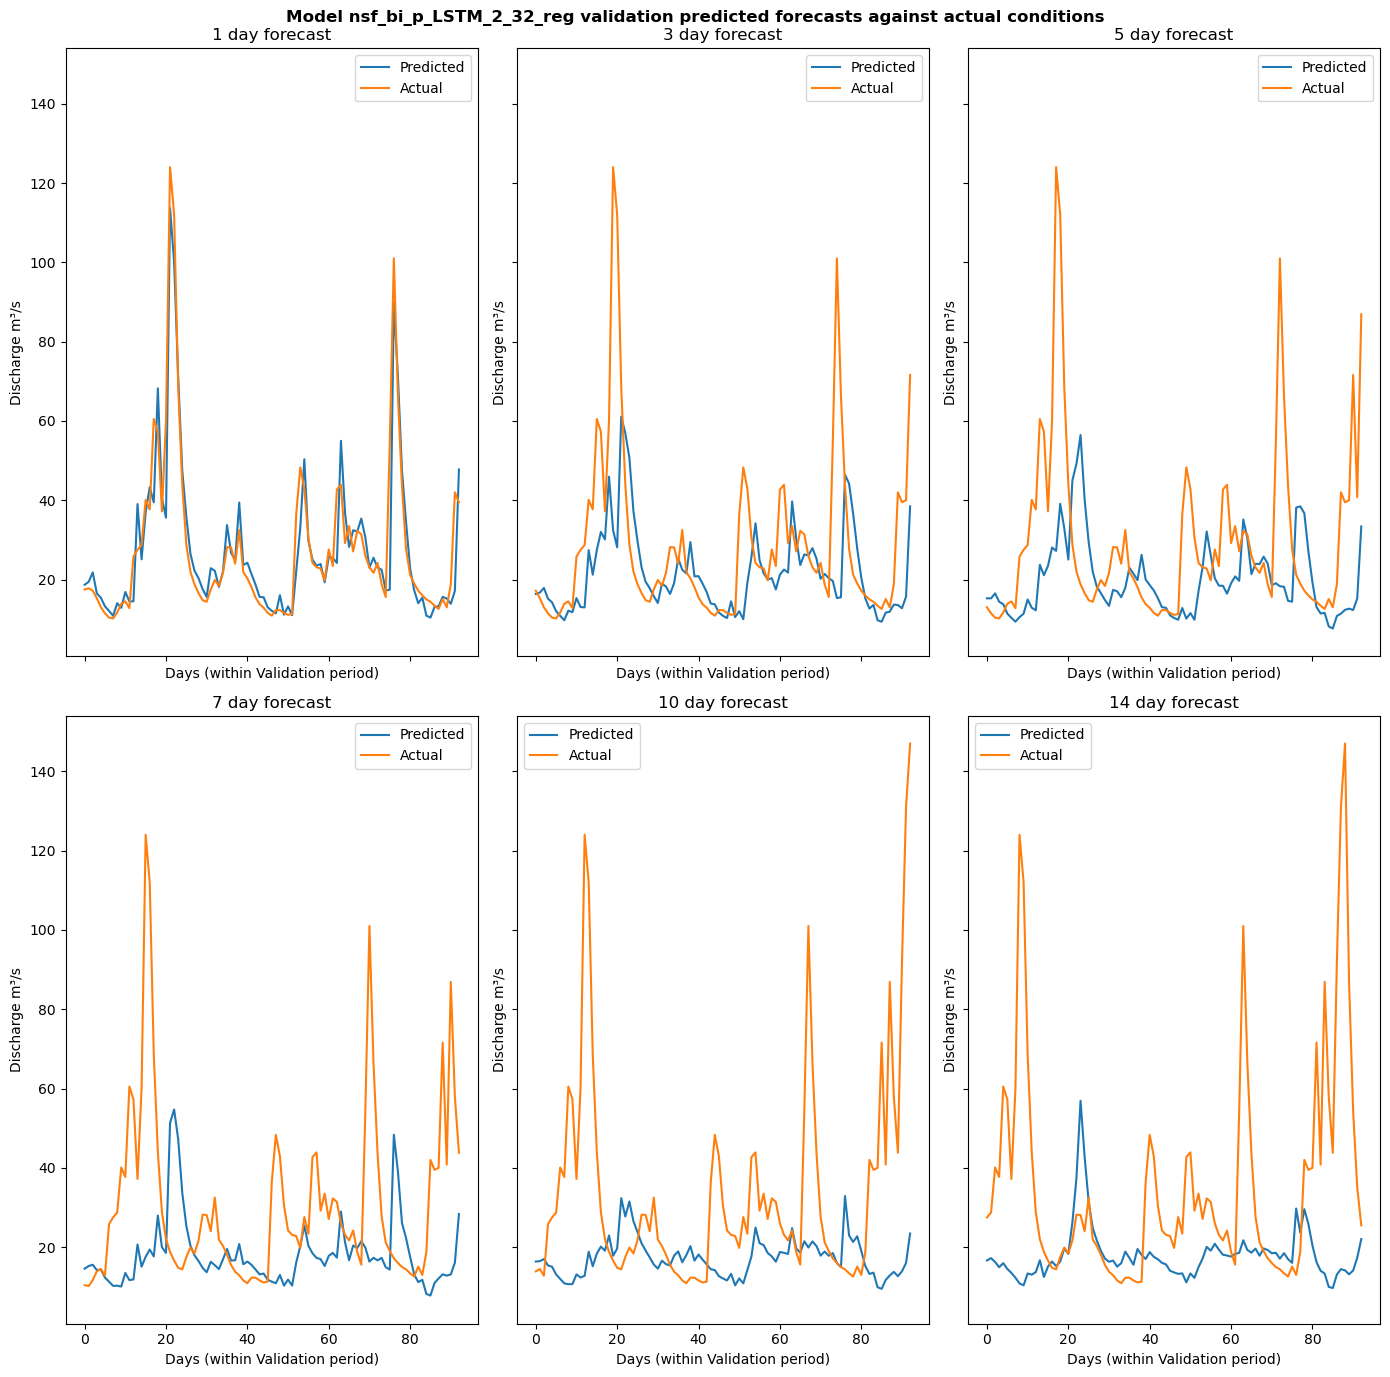

3/3 [==============================] - 0s 3ms/step
(6, 94)


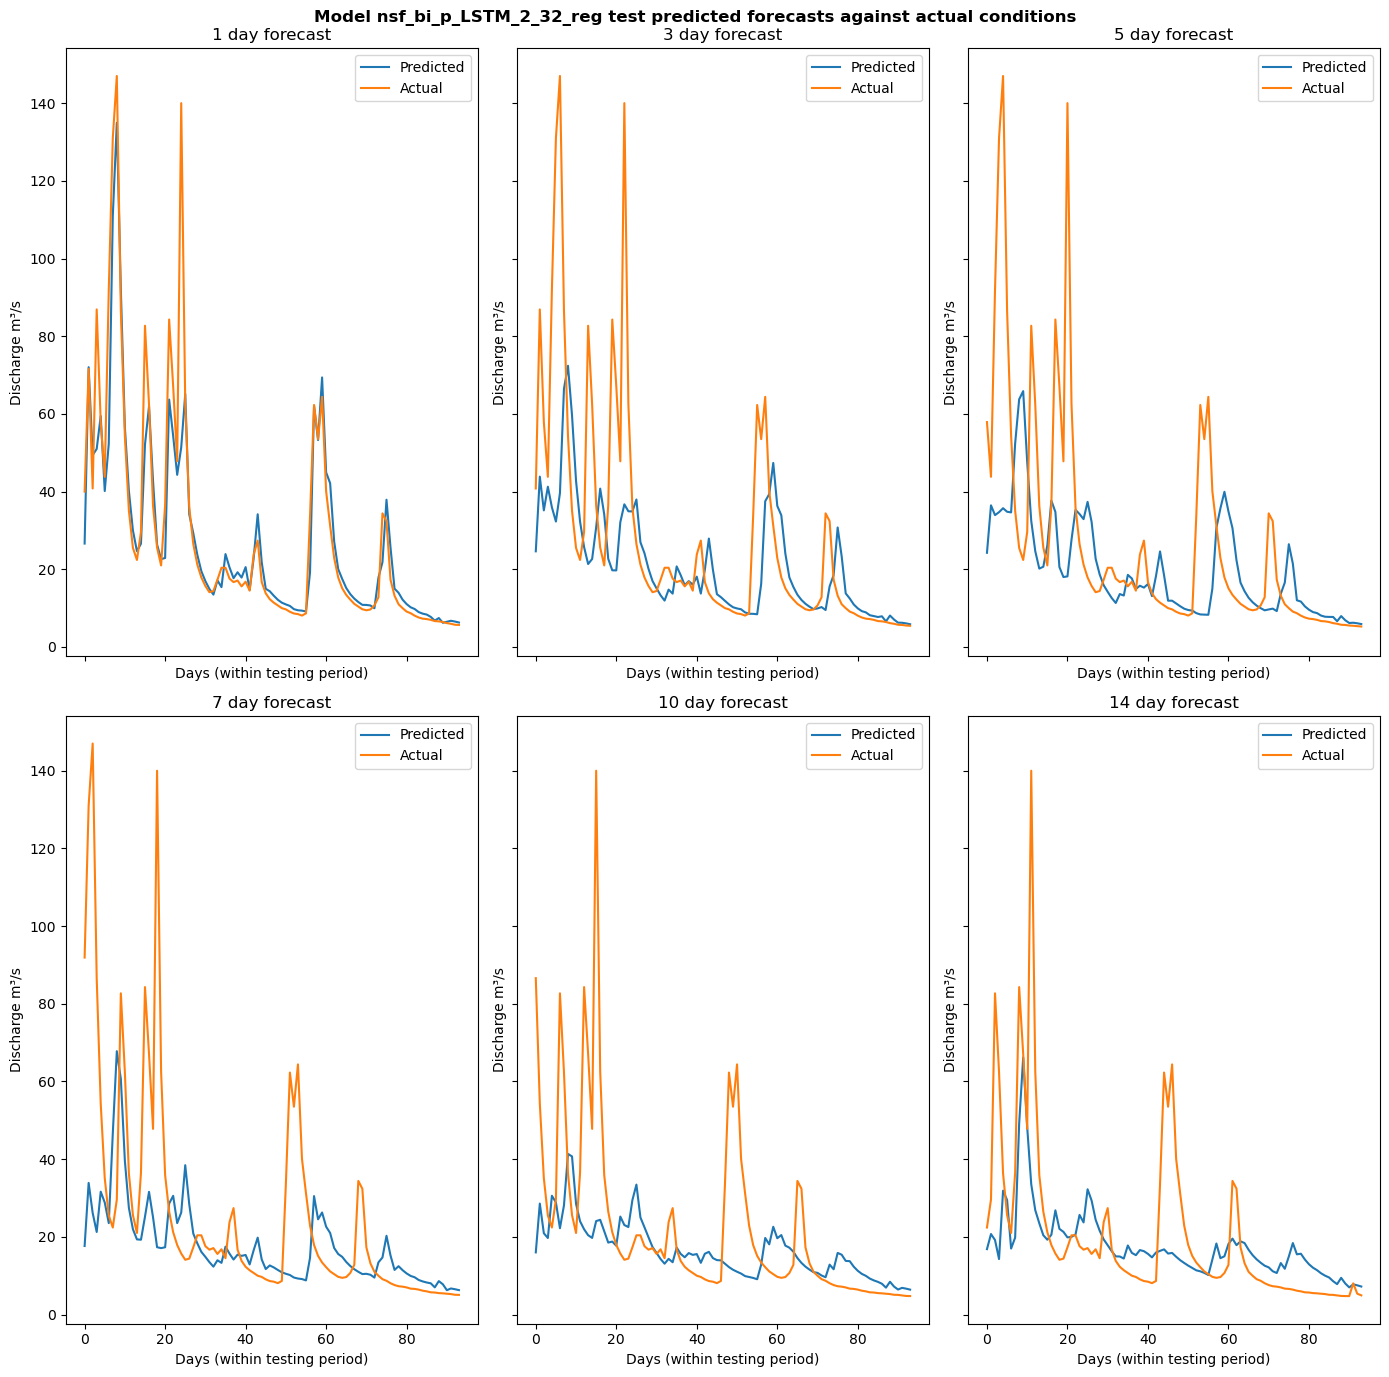

<Figure size 640x480 with 0 Axes>

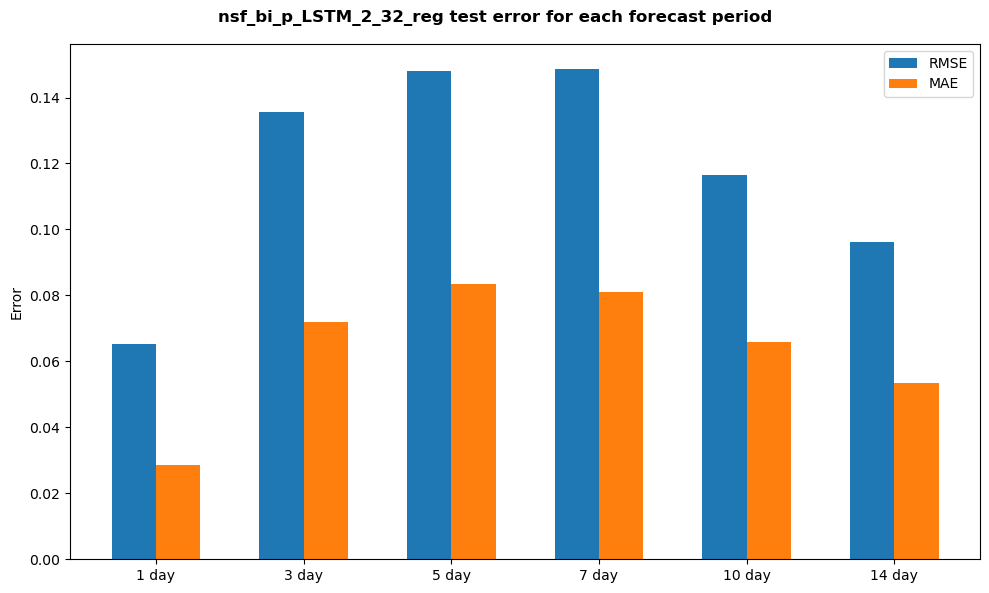

(6, 93)


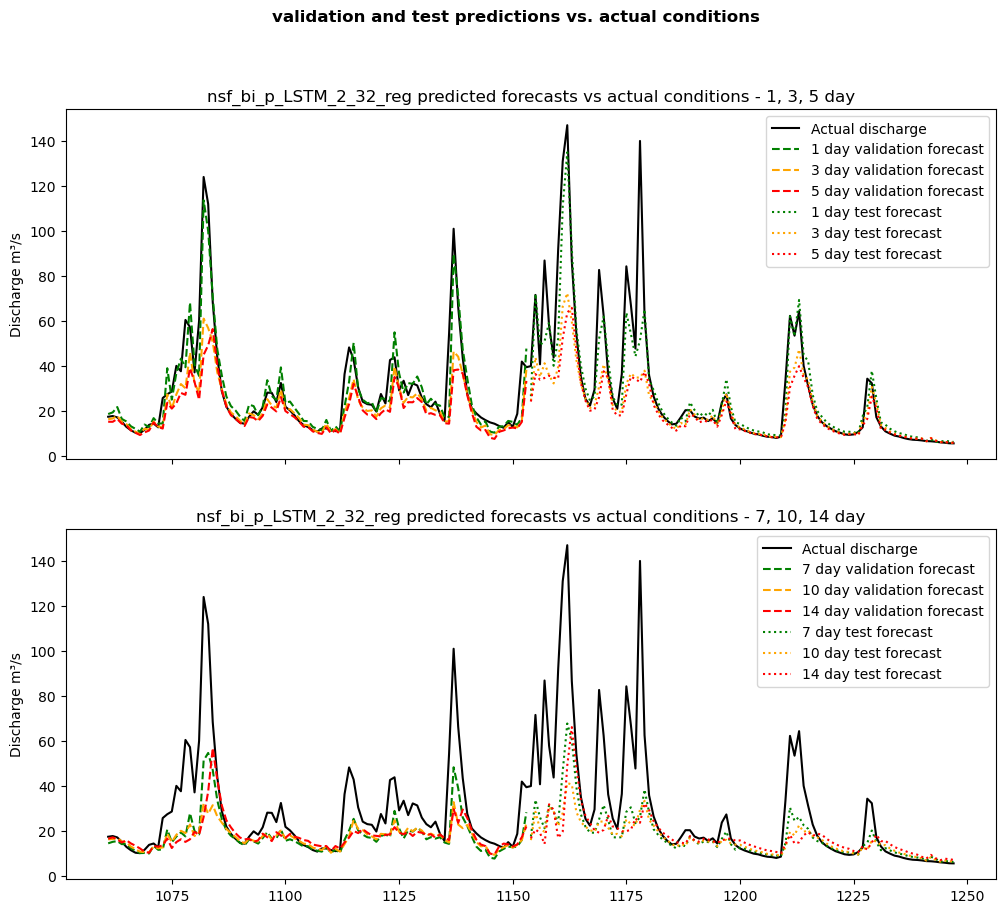

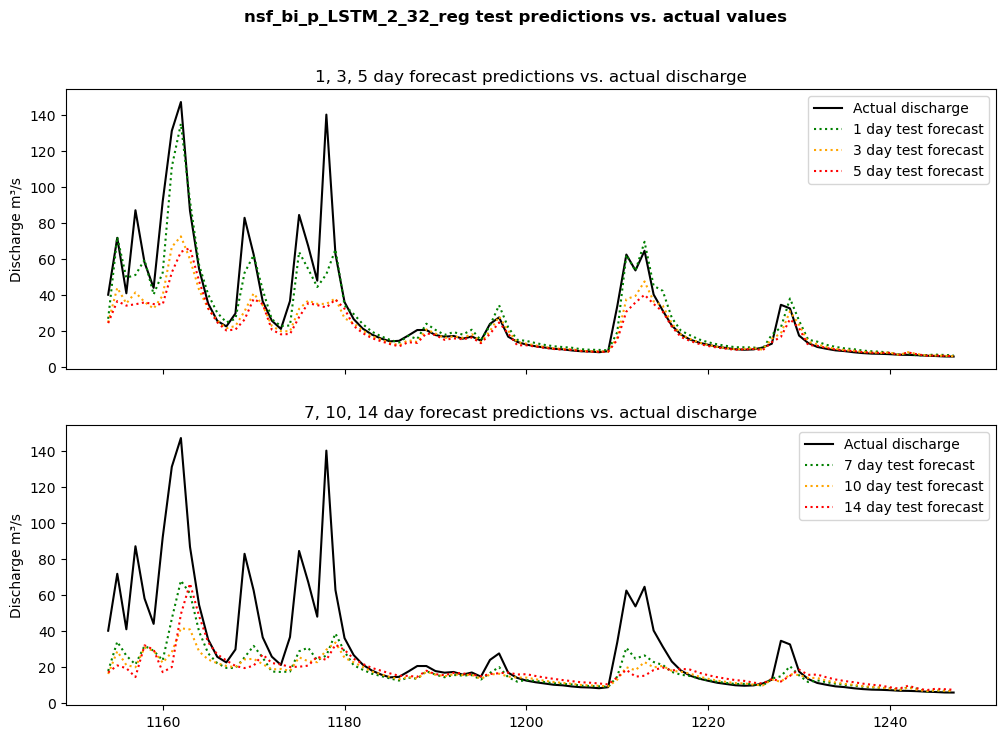

In [23]:
plot_training_metrics(nsf_bi_p_lstm_2_32_reg_hist, nsf_bi_p_lstm_2_32_reg_name)

nsf_bi_p_lstm_2_32_reg_val_results_df, nsf_bi_p_lstm_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(nsf_X_val_3D_scaled, nsf_y_train, nsf_y_val, nsf_y_val_scaled, nsf_bi_p_lstm_2_32_reg, nsf_bi_p_lstm_2_32_reg_name)

nsf_bi_p_lstm_2_32_reg_test_results_df, nsf_bi_p_lstm_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(nsf_X_test_3D_scaled, nsf_y_train, nsf_y_test, nsf_y_test_scaled, nsf_bi_p_lstm_2_32_reg, nsf_bi_p_lstm_2_32_reg_name)

plot_all_model_predictions_vs_actuals(nsf_bi_p_lstm_2_32_reg_all_val_predictions, nsf_bi_p_lstm_2_32_reg_all_test_predictions, nsf_bi_p_lstm_2_32_reg_name, nsf_y, nsf_X_train, nsf_X_val, nsf_X_test)

plot_model_test_predictions_vs_actuals(nsf_bi_p_lstm_2_32_reg_all_test_predictions, nsf_bi_p_lstm_2_32_reg_name, nsf_y, nsf_X_train, nsf_X_val, nsf_X_test)

**Model run 3:- Only Spen Farm**

In [24]:
osf_bi_p_lstm_2_32_reg_name = 'osf_bi_p_LSTM_2_32_reg'

osf_bi_p_lstm_2_32_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, input_shape = osf_X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

osf_bi_p_lstm_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

osf_bi_p_lstm_2_32_reg_hist = osf_bi_p_lstm_2_32_reg.fit(osf_X_train_3D_scaled, osf_y_train_scaled,
                            validation_data = (osf_X_val_3D_scaled, osf_y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 8s 27ms/step - loss: 0.0664 - root_mean_squared_error: 0.1142 - mean_absolute_error: 0.0664 - mean_squared_logarithmic_error: 0.0076 - val_loss: 0.0879 - val_root_mean_squared_error: 0.1422 - val_mean_absolute_error: 0.0879 - val_mean_squared_logarithmic_error: 0.0127 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0491 - root_mean_squared_error: 0.0967 - mean_absolute_error: 0.0491 - mean_squared_logarithmic_error: 0.0061 - val_loss: 0.0870 - val_root_mean_squared_error: 0.1390 - val_mean_absolute_error: 0.0870 - val_mean_squared_logarithmic_error: 0.0121 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0480 - root_mean_squared_error: 0.0952 - mean_absolute_error: 0.0480 - mean_squared_logarithmic_error: 0.0059 - val_loss: 0.0986 - val_root_mean_squared_error: 0.1550 - val_mean_absolute_error: 0.0986 - val_mean_squared_logarithmic_error: 0.0157 - lr: 0.00

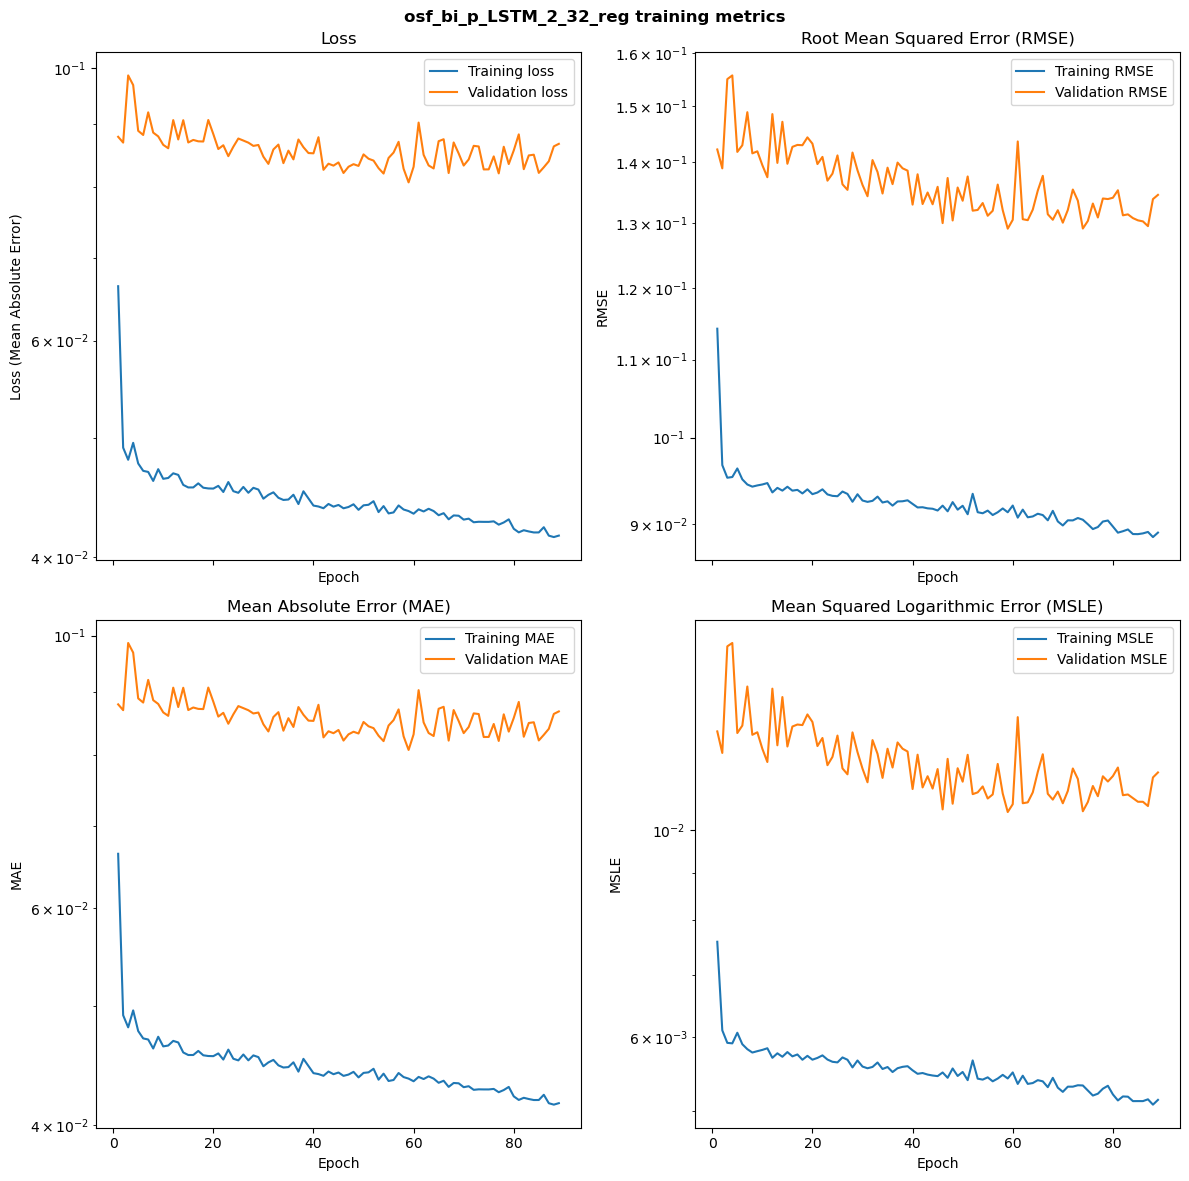

3/3 [==============================] - 1s 3ms/step
(6, 93)


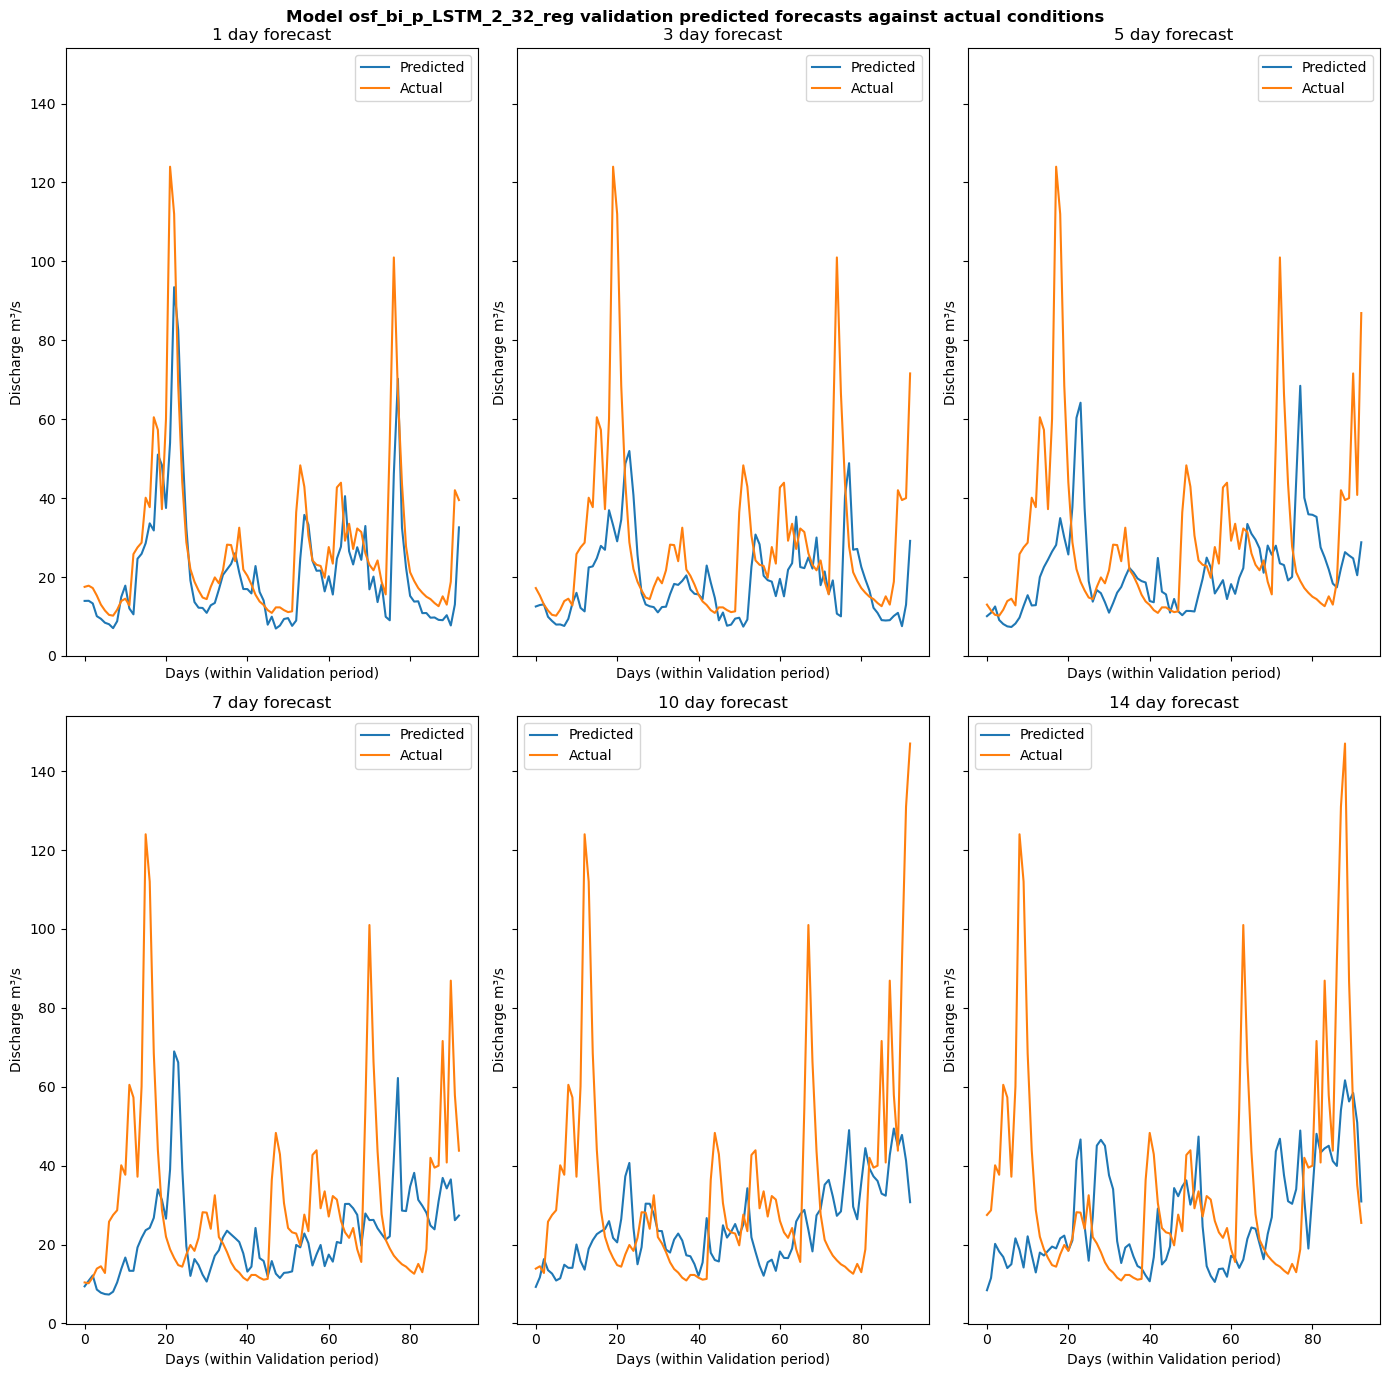

3/3 [==============================] - 0s 3ms/step
(6, 94)


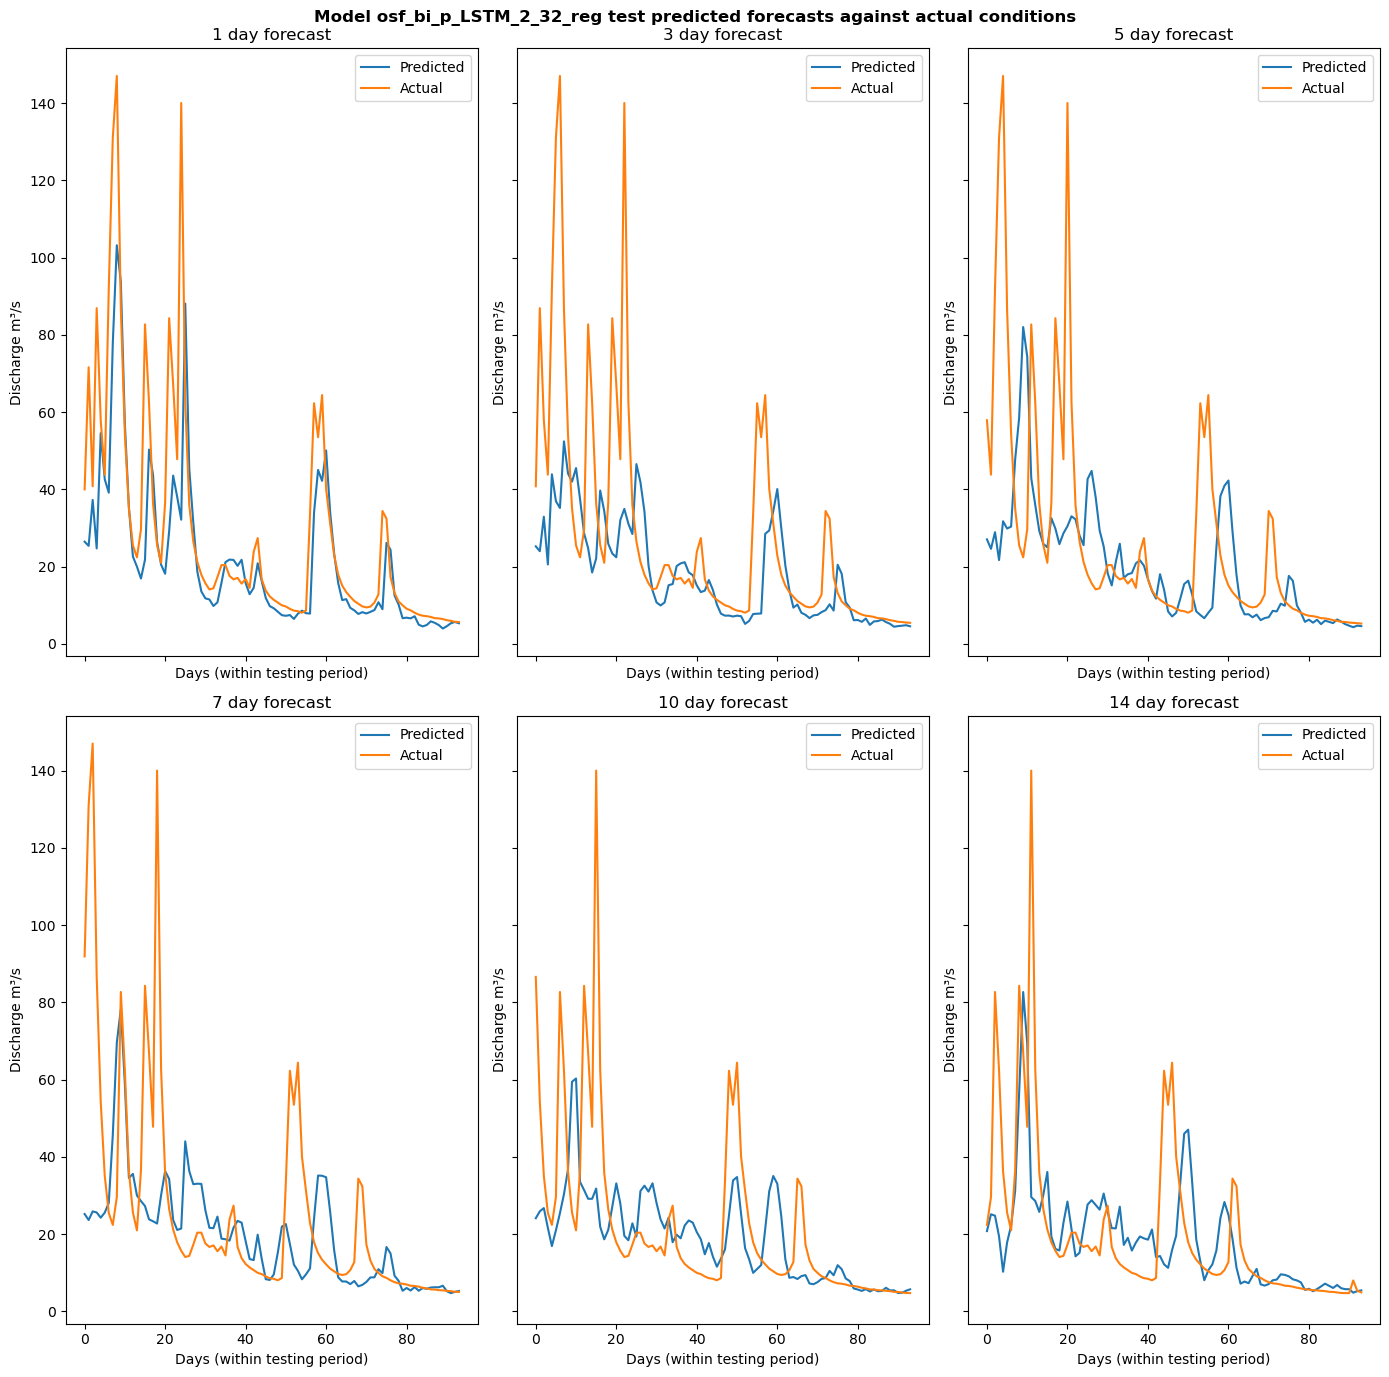

<Figure size 640x480 with 0 Axes>

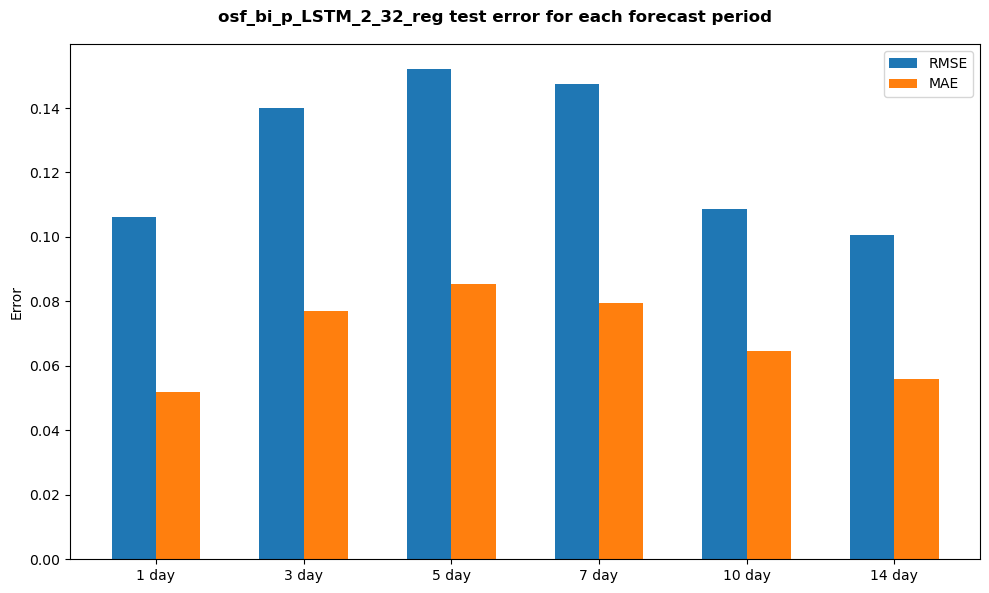

(6, 93)


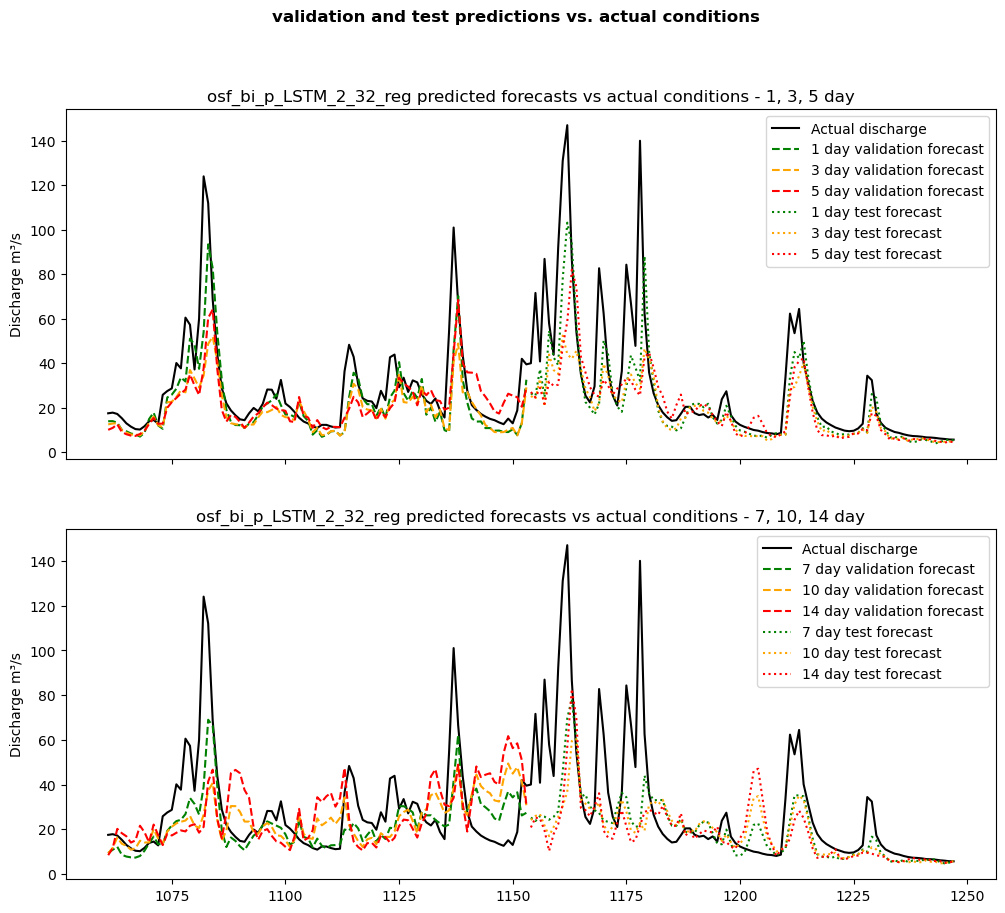

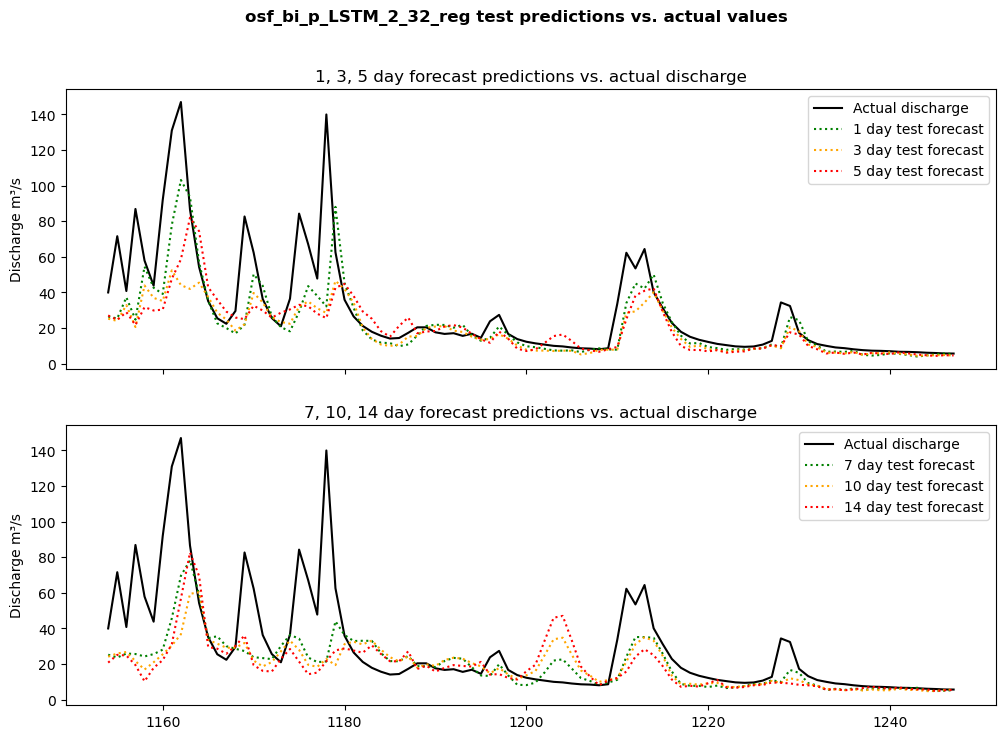

In [25]:
plot_training_metrics(osf_bi_p_lstm_2_32_reg_hist, osf_bi_p_lstm_2_32_reg_name)

osf_bi_p_lstm_2_32_reg_val_results_df, osf_bi_p_lstm_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(osf_X_val_3D_scaled, osf_y_train, osf_y_val, osf_y_val_scaled, osf_bi_p_lstm_2_32_reg, osf_bi_p_lstm_2_32_reg_name)

osf_bi_p_lstm_2_32_reg_test_results_df, osf_bi_p_lstm_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(osf_X_test_3D_scaled, osf_y_train, osf_y_test, osf_y_test_scaled, osf_bi_p_lstm_2_32_reg, osf_bi_p_lstm_2_32_reg_name)

plot_all_model_predictions_vs_actuals(osf_bi_p_lstm_2_32_reg_all_val_predictions, osf_bi_p_lstm_2_32_reg_all_test_predictions, osf_bi_p_lstm_2_32_reg_name, osf_y, osf_X_train, osf_X_val, osf_X_test)

plot_model_test_predictions_vs_actuals(osf_bi_p_lstm_2_32_reg_all_test_predictions, osf_bi_p_lstm_2_32_reg_name, osf_y, osf_X_train, osf_X_val, osf_X_test)

**Model run 4:- No precipitation**

In [26]:
np_bi_p_lstm_2_32_reg_name = 'np_bi_p_LSTM_2_32_reg'

np_bi_p_lstm_2_32_reg = Sequential([
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, input_shape = np_X.shape[1:], kernel_constraint = NonNeg()), return_sequences = True)),
    LayerNormalization(),
    Bidirectional(RNN(PeepholeLSTMCell(units = 32, kernel_constraint = NonNeg()), return_sequences = False)),
    Flatten(),
    Dense(units = FORECAST_LENGTH, activation = 'linear', kernel_constraint = NonNeg())
    
])

np_bi_p_lstm_2_32_reg.compile(loss = 'mean_absolute_error',
               optimizer = Adam(),
               metrics = [RootMeanSquaredError(),
             MeanAbsoluteError(),
             MeanSquaredLogarithmicError()]
            )

np_bi_p_lstm_2_32_reg_hist = np_bi_p_lstm_2_32_reg.fit(np_X_train_3D_scaled, np_y_train_scaled,
                            validation_data = (np_X_val_3D_scaled, np_y_val_scaled),
                            epochs = 250,
                            callbacks = [reduce_lr_on_plateau,
                                        early_stopping]
                                          )

Epoch 1/250
34/34 [==============================] - 7s 28ms/step - loss: 0.0656 - root_mean_squared_error: 0.1116 - mean_absolute_error: 0.0656 - mean_squared_logarithmic_error: 0.0075 - val_loss: 0.0898 - val_root_mean_squared_error: 0.1464 - val_mean_absolute_error: 0.0898 - val_mean_squared_logarithmic_error: 0.0137 - lr: 0.0010
Epoch 2/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0485 - root_mean_squared_error: 0.0965 - mean_absolute_error: 0.0485 - mean_squared_logarithmic_error: 0.0061 - val_loss: 0.0927 - val_root_mean_squared_error: 0.1506 - val_mean_absolute_error: 0.0927 - val_mean_squared_logarithmic_error: 0.0146 - lr: 0.0010
Epoch 3/250
34/34 [==============================] - 0s 6ms/step - loss: 0.0475 - root_mean_squared_error: 0.0953 - mean_absolute_error: 0.0475 - mean_squared_logarithmic_error: 0.0059 - val_loss: 0.0939 - val_root_mean_squared_error: 0.1506 - val_mean_absolute_error: 0.0939 - val_mean_squared_logarithmic_error: 0.0147 - lr: 0.00

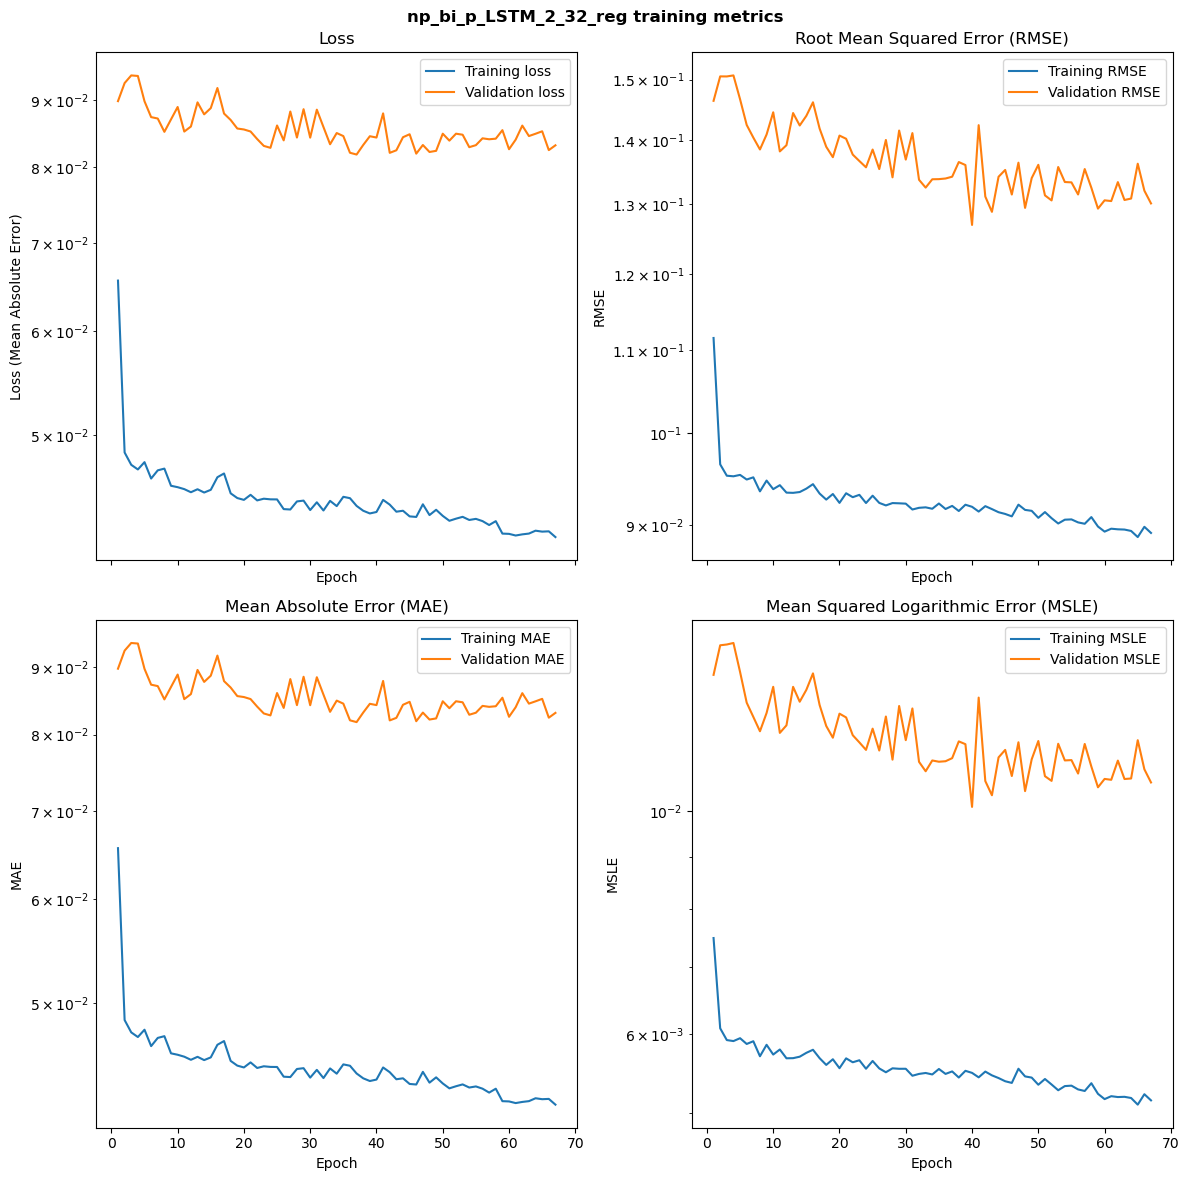

3/3 [==============================] - 1s 2ms/step
(6, 93)


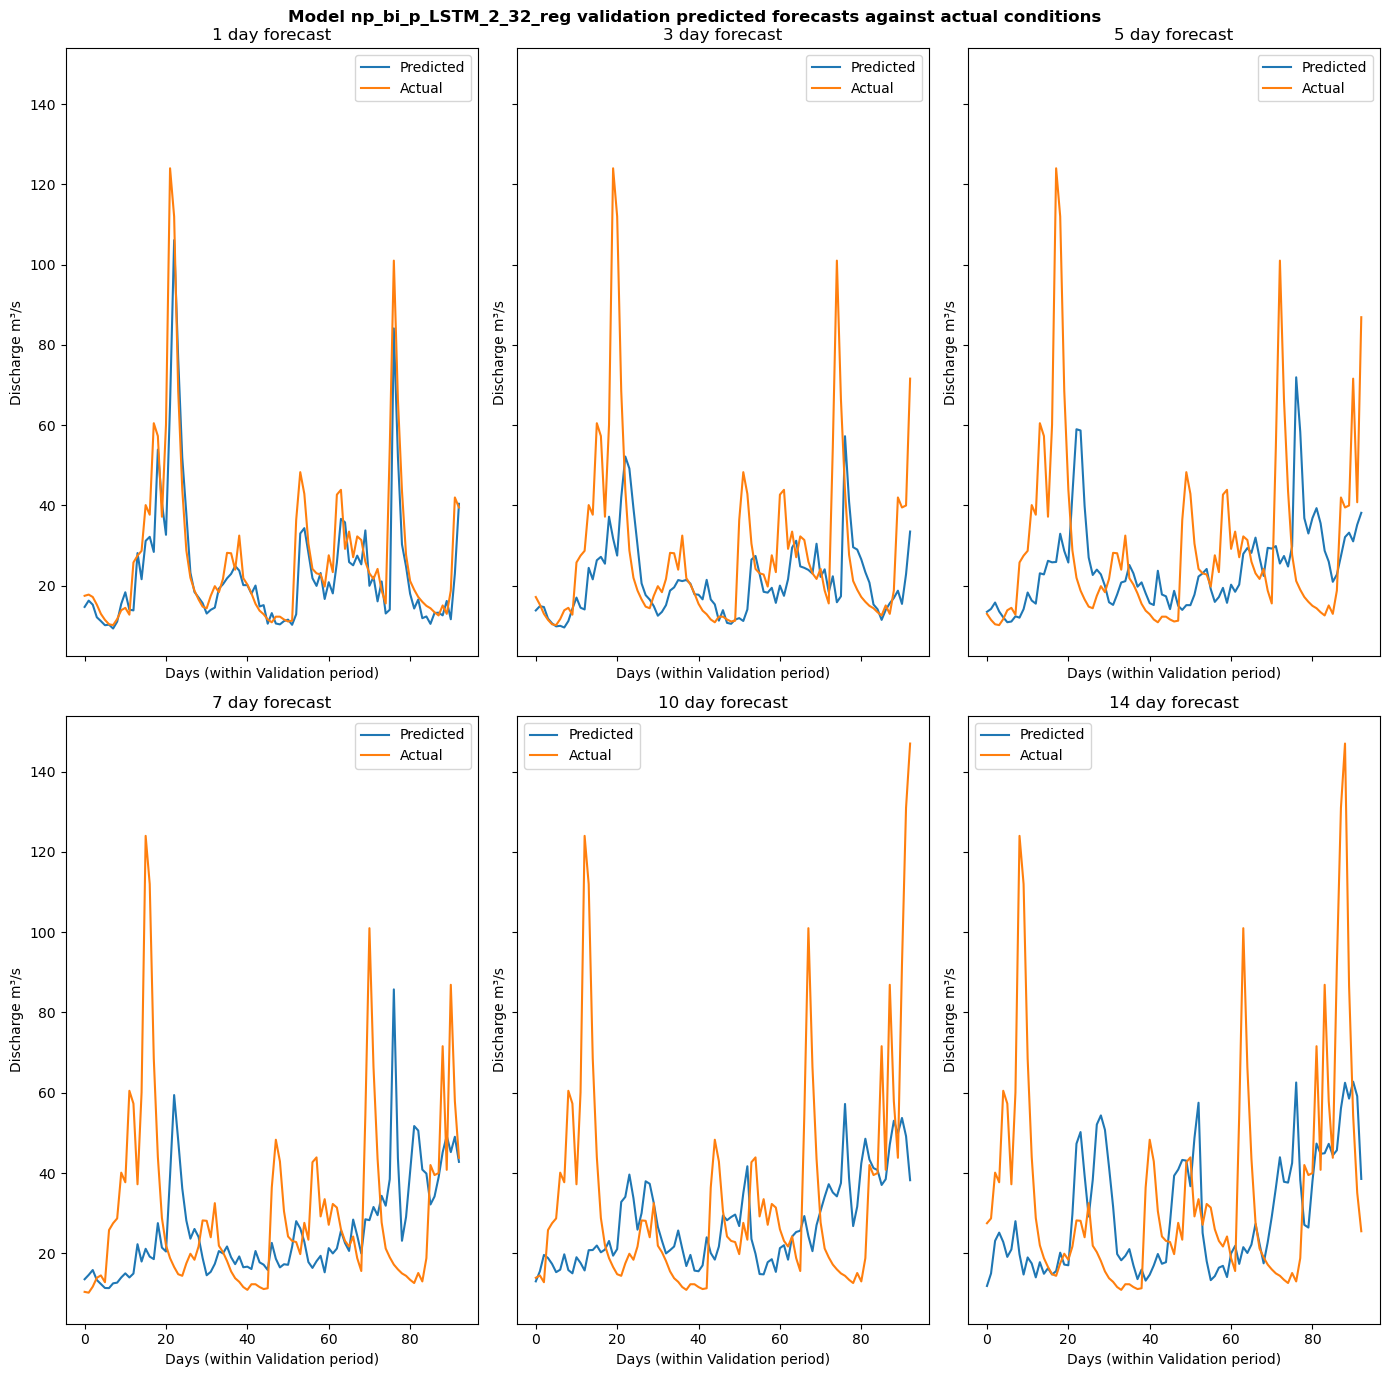

3/3 [==============================] - 0s 3ms/step
(6, 94)


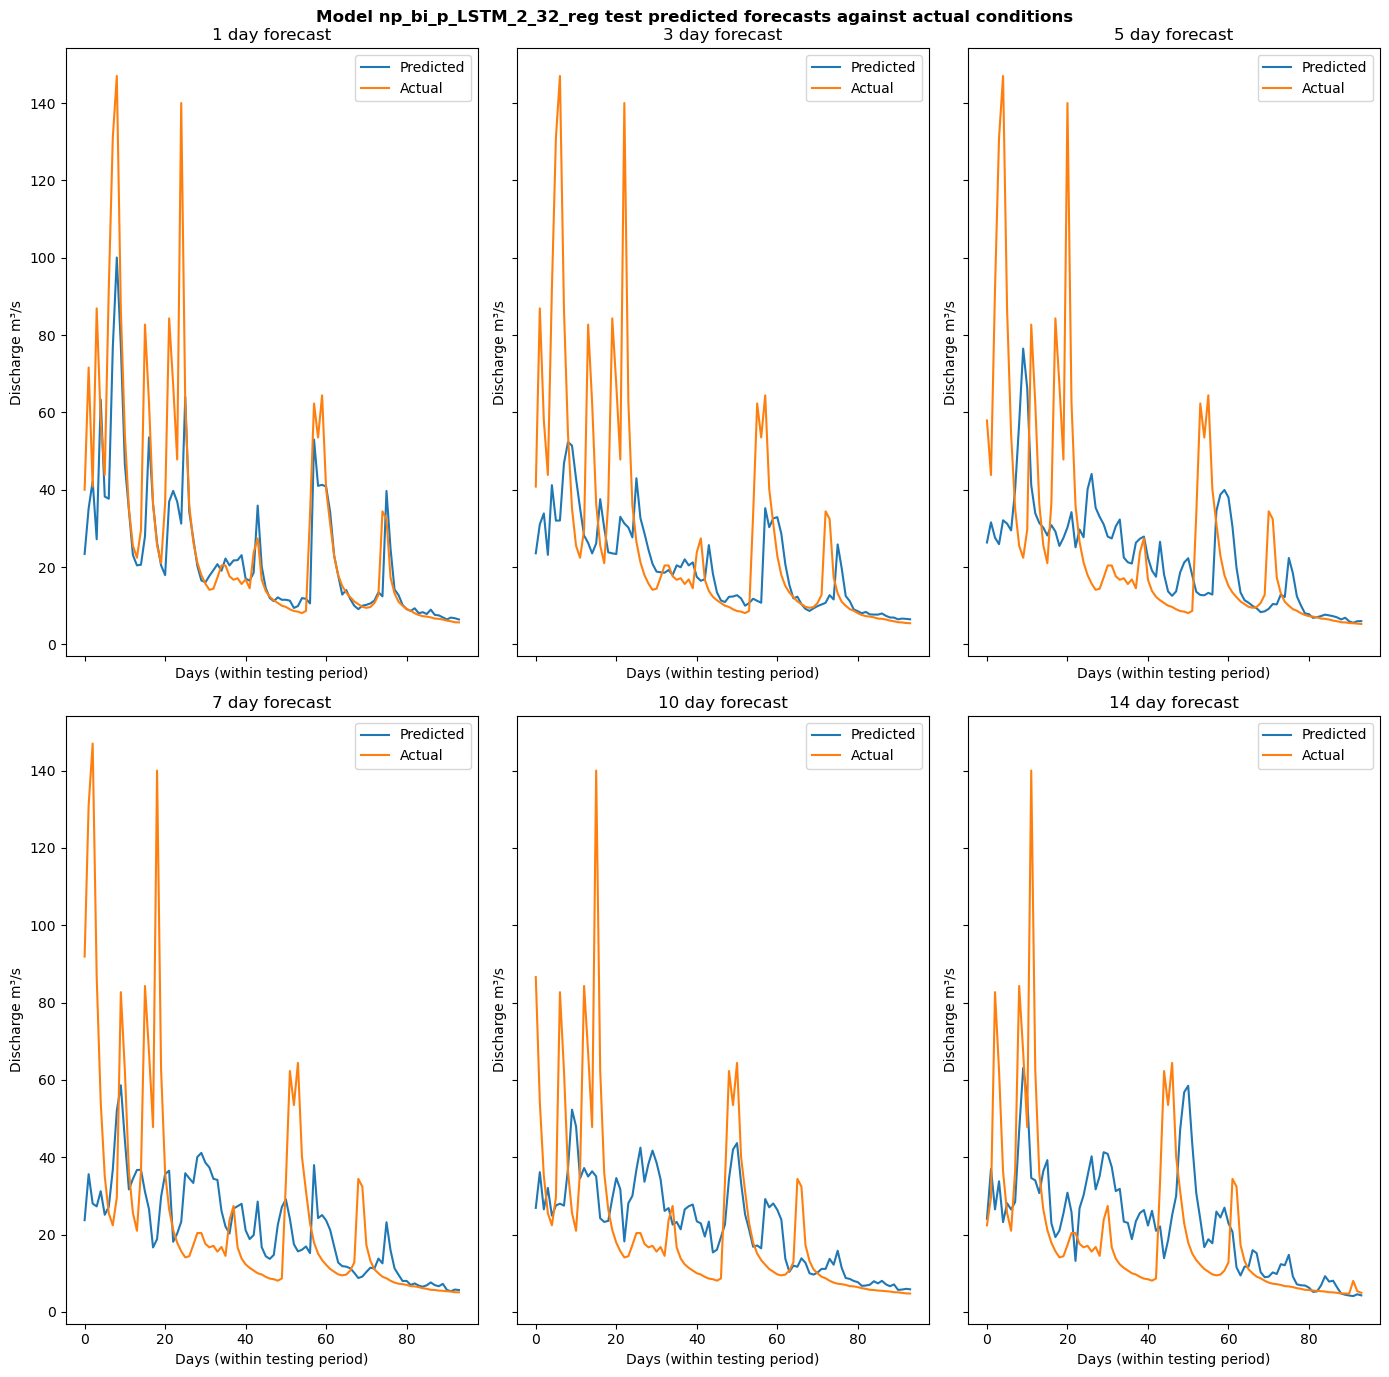

<Figure size 640x480 with 0 Axes>

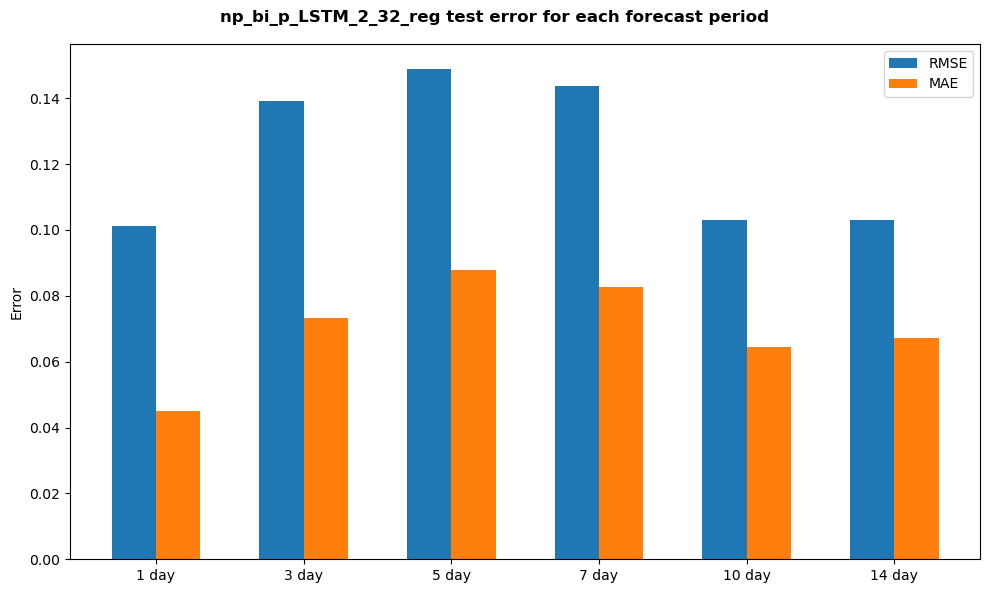

(6, 93)


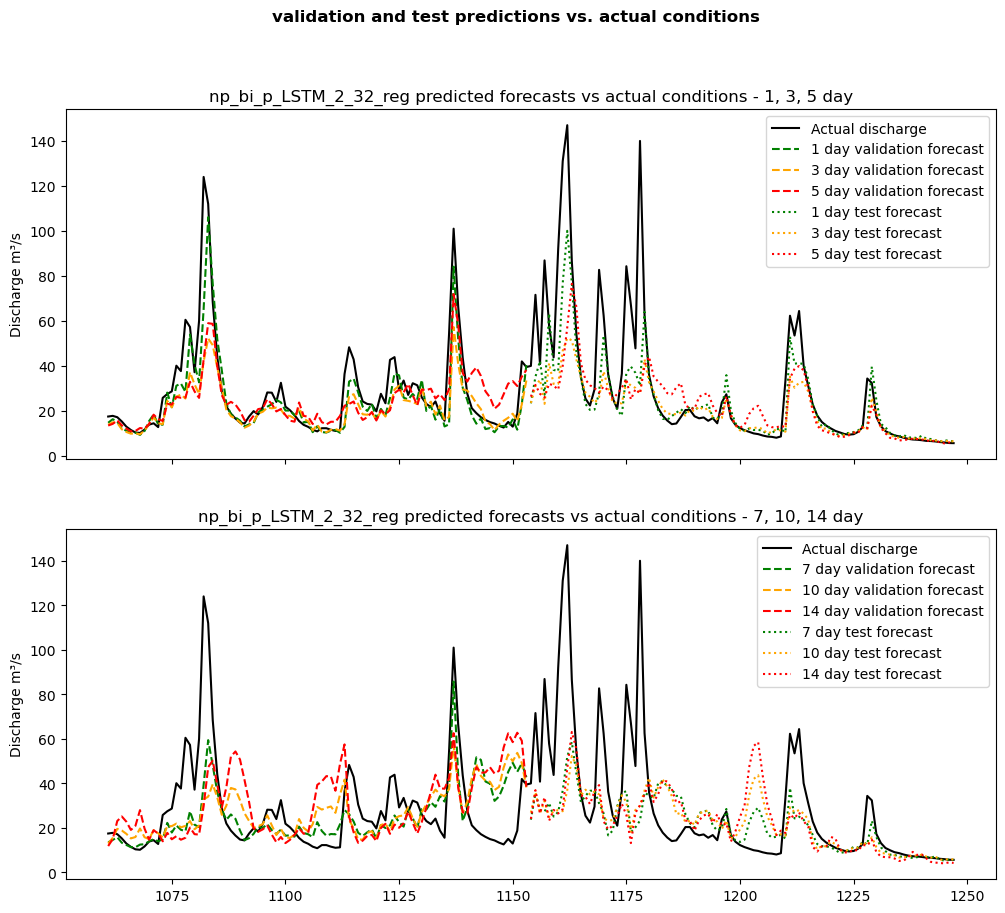

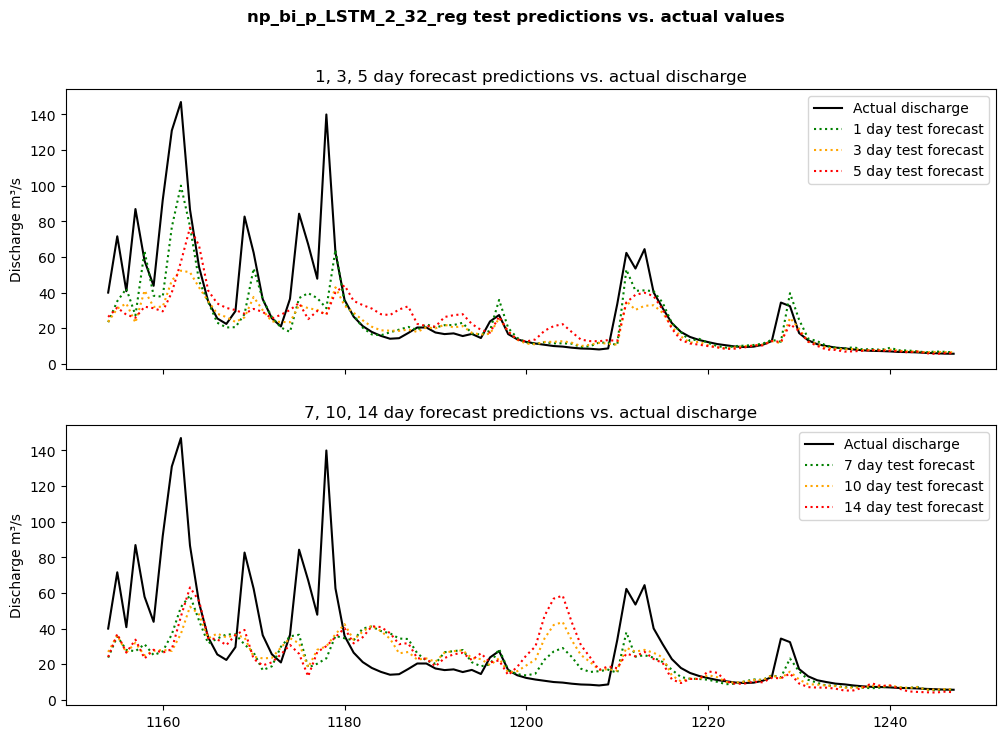

In [27]:
plot_training_metrics(np_bi_p_lstm_2_32_reg_hist, np_bi_p_lstm_2_32_reg_name)

np_bi_p_lstm_2_32_reg_val_results_df, np_bi_p_lstm_2_32_reg_all_val_predictions = plot_validation_predictions_vs_validation_labels(np_X_val_3D_scaled, np_y_train, np_y_val, np_y_val_scaled, np_bi_p_lstm_2_32_reg, np_bi_p_lstm_2_32_reg_name)

np_bi_p_lstm_2_32_reg_test_results_df, np_bi_p_lstm_2_32_reg_all_test_predictions = plot_test_predictions_vs_test_labels(np_X_test_3D_scaled, np_y_train, np_y_test, np_y_test_scaled, np_bi_p_lstm_2_32_reg, np_bi_p_lstm_2_32_reg_name)

plot_all_model_predictions_vs_actuals(np_bi_p_lstm_2_32_reg_all_val_predictions, np_bi_p_lstm_2_32_reg_all_test_predictions, np_bi_p_lstm_2_32_reg_name, np_y, np_X_train, np_X_val, np_X_test)

plot_model_test_predictions_vs_actuals(np_bi_p_lstm_2_32_reg_all_test_predictions, np_bi_p_lstm_2_32_reg_name, np_y, np_X_train, np_X_val, np_X_test)

**Evaluate each model's overall performance**

In [31]:
op_eval = op_bi_p_lstm_2_32_reg.evaluate(op_X_test_3D_scaled, op_y_test_scaled, return_dict = True)
nsf_eval = nsf_bi_p_lstm_2_32_reg.evaluate(nsf_X_test_3D_scaled, nsf_y_test_scaled, return_dict = True)
osf_eval = osf_bi_p_lstm_2_32_reg.evaluate(osf_X_test_3D_scaled, osf_y_test_scaled, return_dict = True)
np_eval = np_bi_p_lstm_2_32_reg.evaluate(np_X_test_3D_scaled, np_y_test_scaled, return_dict = True)

3/3 [==============================] - 0s 3ms/step - loss: 0.0721 - root_mean_squared_error: 0.1251 - mean_absolute_error: 0.0721 - mean_squared_logarithmic_error: 0.0094
